# Telecom Churn Prediction


The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#!pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
data.describe()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  69999.000000    69999.0         69297.0         69297.0   
mean   34999.000000      109.0             0.0             0.0   
std    20207.115084        0.0             0.0             0.0   
min        0.000000      109.0             0.0             0.0   
25%    17499.500000      109.0             0.0             0.0   
50%    34999.000000      109.0             0.0             0.0   
75%    52498.500000      109.0             0.0             0.0   
max    69998.000000      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count         69297.0  69999.000000  69999.000000  69999.000000  67231.000000   
mean              0.0    283.134365    278.185912    278.858826    133.153275   
std               0.0    334.213918    344.366927    351.924315    299.963093   
min               0.0  -2258.709000  -1289.715000   -945.808000      0.000000   
25%               0.0     93.581000     86.714000     84.095000      7.410000   
50%               0.0    197.484000    191.588000    192.234000     34.110000   
75%               0.0    370.791000    365.369500    369.909000    119.390000   
max               0.0  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  67312.000000  66296.000000  67231.000000  67312.000000  66296.000000   
mean     133.894438    132.978257    198.874771    197.153383    196.543577   
std      311.277193    311.896596    316.818355    322.482226    324.089234   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.675000      6.410000     34.860000     32.240000     31.575000   
50%       32.280000     32.100000     96.480000     91.885000     91.800000   
75%      115.837500    115.060000    232.990000    227.630000    229.345000   
max     8157.780000  10752.560000   8362.360000   7043.980000  14007.340000   

       roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
count   67231.000000   67312.000000   66296.000000   67231.000000   
mean        9.765435       7.014568       7.004892      14.186457   
std        57.374429      55.960985      53.408135      73.469261   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      2850.980000    4155.830000    4169.810000    3775.110000   

       roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   67312.000000   66296.000000      67231.000000      67312.000000   
mean        9.842191       9.771783         46.904854         46.166503   
std        58.511894      64.618388        150.971758        154.739002   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.650000   
50%         0.000000       0.000000         11.910000         11.580000   
75%         0.000000       0.000000         40.740000         39.760000   
max      2812.040000    5337.040000       6431.330000       7400.660000   

       loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
count      66296.000000      67231.000000      67312.000000      66296.000000   
mean          45.686109         93.238231         90.799240         91.121447   
std          153.716880        162.046699        153.852597        152.997805   
min            0.000000          0.000000          0.000000          0.000000   
25%            1.610000          9.920000         10.090000          9.830000   
50%           11.740000         41.030000         40.170000         40.350000   
75%           39.895000        110.430000        107.540000        109.245000   
max        10752.560000       4696

In [5]:
# Cheking percent of missing values in columns
df_missing_columns = (round(((data.isnull().sum()/len(data.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

null
arpu_3g_6                 74.90
count_rech_2g_6           74.90
night_pck_user_6          74.90
arpu_2g_6                 74.90
date_of_last_rech_data_6  74.90
total_rech_data_6         74.90
av_rech_amt_data_6        74.90
max_rech_data_6           74.90
count_rech_3g_6           74.90
fb_user_6                 74.90
night_pck_user_7          74.48
date_of_last_rech_data_7  74.48
total_rech_data_7         74.48
max_rech_data_7           74.48
fb_user_7                 74.48
count_rech_2g_7           74.48
count_rech_3g_7           74.48
arpu_3g_7                 74.48
av_rech_amt_data_7        74.48
arpu_2g_7                 74.48
count_rech_2g_8           73.69
av_rech_amt_data_8        73.69
night_pck_user_8          73.69
max_rech_data_8           73.69
total_rech_data_8         73.69
arpu_2g_8                 73.69
arpu_3g_8                 73.69
date_of_last_rech_data_8  73.69
fb_user_8                 73.69
count_rech_3g_8           73.69
isd_og_mou_8               5.29
std_ic_t2o_mou_8           5.29
std_og_t2c_mou_8           5.29
std_ic_t2f_mou_8           5.29
std_og_mou_8               5.29
std_ic_t2m_mou_8           5.29
std_ic_mou_8               5.29
std_ic_t2t_mou_8           5.29
og_others_8                5.29
spl_og_mou_8               5.29
loc_ic_t2m_mou_8           5.29
loc_ic_mou_8               5.29
loc_ic_t2f_mou_8           5.29
std_og_t2f_mou_8           5.29
loc_og_t2c_mou_8           5.29
ic_others_8                5.29
loc_og_mou_8               5.29
onnet_mou_8                5.29
offnet_mou_8               5.29
roam_ic_mou_8              5.29
roam_og_mou_8              5.29
loc_og_t2t_mou_8           5.29
loc_og_t2m_mou_8           5.29
loc_og_t2f_mou_8           5.29
std_og_t2m_mou_8           5.29
loc_ic_t2t_mou_8           5.29
isd_ic_mou_8               5.29
std_og_t2t_mou_8           5.29
spl_ic_mou_8               5.29
std_ic_t2m_mou_6           3.95
std_ic_t2t_mou_6           3.95
loc_ic_t2m_mou_6           3.95
ic_others_6                3.95
loc_ic_mou_6               3.95
std_ic_t2f_mou_6           3.95
isd_ic_mou_6               3.95
std_ic_mou_6               3.95
spl_ic_mou_6               3.95
std_ic_t2o_mou_6           3.95
loc_ic_t2f_mou_6           3.95
isd_og_mou_6               3.95
std_og_t2m_mou_6           3.95
std_og_t2f_mou_6           3.95
loc_og_mou_6               3.95
loc_og_t2c_mou_6           3.95
std_og_t2c_mou_6           3.95
loc_og_t2f_mou_6           3.95
loc_og_t2m_mou_6           3.95
std_og_mou_6               3.95
loc_og_t2t_mou_6           3.95
std_og_t2t_mou_6           3.95
loc_ic_t2t_mou_6           3.95
spl_og_mou_6               3.95
onnet_mou_6                3.95
roam_ic_mou_6              3.95
og_others_6                3.95
roam_og_mou_6              3.95
offnet_mou_6               3.95
roam_og_mou_7              3.84
ic_others_7                3.84
loc_og_mou_7               3.84
onnet_mou_7                3.84
loc_ic_t2t_mou_7           3.84
loc_og_t2f_mou_7           3.84
loc_og_t2c_mou_7           3.84
offnet_mou_7               3.84
loc_og_t2m_mou_7           3.84
roam_ic_mou_7              3.84
std_og_t2t_mou_7           3.84
loc_og_t2t_mou_7           3.84
loc_ic_t2m_mou_7           3.84
isd_ic_mou_7               3.84
loc_ic_t2f_mou_7           3.84
loc_ic_mou_7               3.84
spl_og_mou_7               3.84
std_ic_t2t_mou_7           3.84
isd_og_mou_7               3.84
std_ic_t2m_mou_7           3.84
std_og_mou_7               3.84
std_ic_t2f_mou_7           3.84
std_og_t2m_mou_7           3.84
std_ic_t2o_mou_7           3.84
std_og_t2c_mou_7           3.84
std_ic_mou_7               3.84
std_og_t2f_mou_7           3.84
og_others_7                3.84
spl_ic_mou_7               3.84
date_of_last_rech_8        3.52
date_of_last_rech_7        1.76
date_of_last_rech_6        1.57
last_date_of_month_8       1.05
loc_ic_t2o_mou             1.00
std_og_t2o_mou             1.00
loc_og_t2o_mou             1.00
last_date_of_month_7       

In [6]:
# List the columns having more than 70% missing values
col_list_missing_70 = list(df_missing_columns.index[df_missing_columns['null'] > 70])
col_list_missing_70

['arpu_3g_6',
 'count_rech_2g_6',
 'night_pck_user_6',
 'arpu_2g_6',
 'date_of_last_rech_data_6',
 'total_rech_data_6',
 'av_rech_amt_data_6',
 'max_rech_data_6',
 'count_rech_3g_6',
 'fb_user_6',
 'night_pck_user_7',
 'date_of_last_rech_data_7',
 'total_rech_data_7',
 'max_rech_data_7',
 'fb_user_7',
 'count_rech_2g_7',
 'count_rech_3g_7',
 'arpu_3g_7',
 'av_rech_amt_data_7',
 'arpu_2g_7',
 'count_rech_2g_8',
 'av_rech_amt_data_8',
 'night_pck_user_8',
 'max_rech_data_8',
 'total_rech_data_8',
 'arpu_2g_8',
 'arpu_3g_8',
 'date_of_last_rech_data_8',
 'fb_user_8',
 'count_rech_3g_8']

In [7]:
#Drop the columns having > 70 missing data
data = data.drop(col_list_missing_70, axis=1)

In [8]:
data.shape

(69999, 142)

In [9]:
# Dropping all date columns for now . Need to analyze more on 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'
date_cols = [k for k in data.columns.to_list() if 'date' in k]
print(date_cols)

['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']


In [10]:
data = data.drop(date_cols, axis=1)
data.shape

(69999, 136)

In [11]:
# checking aggregrate details of value count of each colum
data.agg(['count','nunique','unique'])

id circle_id  \
count                                                69999     69999   
nunique                                              69999         1   
unique   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...     [109]   

        loc_og_t2o_mou std_og_t2o_mou loc_ic_t2o_mou  \
count            69297          69297          69297   
nunique              1              1              1   
unique      [0.0, nan]     [0.0, nan]     [0.0, nan]   

                                                    arpu_6  \
count                                                69999   
nunique                                              61615   
unique   [31.277, 0.0, 60.806, 156.362, 240.708, 86.193...   

                                                    arpu_7  \
count                                                69999   
nunique                                              61425   
unique   [87.009, 122.787, 103.176, 205.26, 128.191, 83...   

                                                    arpu_8  \
count                                                69999   
nunique                                              60194   
unique   [7.527, 42.953, 0.0, 111.095, 101.565, 88.462,...   

                                               onnet_mou_6  \
count                                                67231   
nunique                                              20057   
unique   [48.58, 0.0, 0.53, 7.26, 21.28, 1.39, 38.81, 2...   

                                               onnet_mou_7  \
count                                                67312   
nunique                                              20076   
unique   [124.38, 0.0, 15.93, 16.01, 4.83, 1.78, 40.56,...   

                                               onnet_mou_8  \
count                                                66296   
nunique                                              19725   
unique   [1.29, 0.0, 6.13, 0.45, 19.61, 53.38, 177.36, ...   

                                              offnet_mou_6  \
count                                                67231   
nunique                                              26254   
unique   [32.24, 0.0, 53.99, 68.76, 56.99, 17.14, 31.63...   

                                              offnet_mou_7  \
count                                                67312   
nunique                                              26139   
unique   [96.68, 25.99, 82.05, 78.48, 38.11, 24.26, 54....   

                                              offnet_mou_8  \
count                                                66296   
nunique                                              25995   
unique   [2.33, 30.89, 0.0, 50.23, 9.63, 3.44, 5.69, 21...   

                                             roam_ic_mou_6  \
count                                                67231   
nunique                                               5306   
unique   [0.0, 53.64, 28.26, 18.56, 28.24, 12.58, nan, ...   

                                             roam_ic_mou_7  \
count                                                67312   
nunique                                               4240   
unique   [0.0, 11.31, 7.23, 3.4, nan, 0.88, 149.04, 43....   

                                             roam_ic_mou_8  \
count                                                66296   
nunique                                               4252   
unique   [0.0, 47.81, 3.46, nan, 0.76, 7.08, 7.26, 69.8...   

                                             roam_og_mou_6  \
count                                                67231   
nunique                                               6568   
unique   [0.0, 15.73, 47.81, 20.3, 45.31, 16.73, nan, 1...   

                                             roam_og_mou_7  \
count                                                67312   
nunique                                               5305   
unique   [0.0, 50.88, 32.28, 3.99, nan, 0.16, 1.15, 388...   

                                             roam_og_mou

In [12]:
total_records = data.shape[0]
total_records

69999

In [13]:
ninty_percent = total_records*0.90 #69999 is the total number of rows
ninty_percent

62999.1

In [14]:
#Drop columns having 90% same data
dropCols = [] 
for i in data.columns :
    if data[i].value_counts().max() >= ninty_percent:
        dropCols.append(i)
print(dropCols)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'og_others_7', 'og_others_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']


In [15]:
data = data.drop(dropCols, axis=1)
data.shape

(69999, 112)

In [16]:
# Cheking percent of missing values in columns
(round(((data.isnull().sum()/len(data.index))*100),2).to_frame('null')).sort_values('null', ascending=False)

null
std_ic_t2t_mou_8    5.29
std_ic_t2f_mou_8    5.29
loc_ic_t2m_mou_8    5.29
loc_ic_t2f_mou_8    5.29
loc_og_t2f_mou_8    5.29
loc_ic_t2t_mou_8    5.29
loc_ic_mou_8        5.29
loc_og_t2m_mou_8    5.29
loc_og_mou_8        5.29
std_og_t2f_mou_8    5.29
loc_og_t2t_mou_8    5.29
std_ic_t2m_mou_8    5.29
roam_og_mou_8       5.29
spl_og_mou_8        5.29
roam_ic_mou_8       5.29
std_og_t2t_mou_8    5.29
std_ic_mou_8        5.29
offnet_mou_8        5.29
spl_ic_mou_8        5.29
onnet_mou_8         5.29
std_og_mou_8        5.29
isd_ic_mou_8        5.29
std_og_t2m_mou_8    5.29
ic_others_8         5.29
loc_og_t2c_mou_8    5.29
loc_ic_t2m_mou_6    3.95
loc_ic_t2t_mou_6    3.95
spl_og_mou_6        3.95
loc_ic_t2f_mou_6    3.95
loc_ic_mou_6        3.95
std_ic_t2t_mou_6    3.95
std_ic_t2m_mou_6    3.95
std_ic_t2f_mou_6    3.95
std_ic_mou_6        3.95
spl_ic_mou_6        3.95
isd_ic_mou_6        3.95
ic_others_6         3.95
std_og_mou_6        3.95
og_others_6         3.95
loc_og_t2m_mou_6    3.95
roam_og_mou_6       3.95
loc_og_t2f_mou_6    3.95
onnet_mou_6         3.95
std_og_t2m_mou_6    3.95
std_og_t2f_mou_6    3.95
offnet_mou_6        3.95
loc_og_t2c_mou_6    3.95
loc_og_t2t_mou_6    3.95
roam_ic_mou_6       3.95
std_og_t2t_mou_6    3.95
loc_og_mou_6        3.95
loc_og_t2t_mou_7    3.84
roam_og_mou_7       3.84
std_ic_t2f_mou_7    3.84
std_og_t2f_mou_7    3.84
roam_ic_mou_7       3.84
std_ic_t2t_mou_7    3.84
offnet_mou_7        3.84
spl_ic_mou_7        3.84
onnet_mou_7         3.84
isd_ic_mou_7        3.84
ic_others_7         3.84
std_ic_mou_7        3.84
std_ic_t2m_mou_7    3.84
loc_og_t2m_mou_7    3.84
loc_og_mou_7        3.84
spl_og_mou_7        3.84
std_og_t2t_mou_7    3.84
loc_ic_mou_7        3.84
std_og_mou_7        3.84
loc_ic_t2t_mou_7    3.84
std_og_t2m_mou_7    3.84
loc_ic_t2m_mou_7    3.84
loc_og_t2c_mou_7    3.84
loc_ic_t2f_mou_7    3.84
loc_og_t2f_mou_7    3.84
vol_2g_mb_6         0.00
vol_2g_mb_7         0.00
vol_2g_mb_8         0.00
vol_3g_mb_6         0.00
last_day_rch_amt_7  0.00
jun_vbc_3g          0.00
last_day_rch_amt_8  0.00
aug_vbc_3g          0.00
jul_vbc_3g          0.00
max_rech_amt_8      0.00
aon                 0.00
vol_3g_mb_7         0.00
vol_3g_mb_8         0.00
sachet_2g_6         0.00
sachet_2g_8         0.00
sachet_2g_7         0.00
last_day_rch_amt_6  0.00
id                  0.00
max_rech_amt_7      0.00
max_rech_amt_6      0.00
arpu_7              0.00
arpu_8              0.00
total_og_mou_6      0.00
total_og_mou_7      0.00
total_og_mou_8      0.00
arpu_6              0.00
total_ic_mou_6      0.00
total_ic_mou_7      0.00
total_ic_mou_8      0.00
total_rech_num_6    0.00
total_rech_num_7    0.00
total_rech_num_8    0.00
total_rech_amt_6    0.00
total_rech_amt_7    0.00
total_rech_amt_8    0.00
churn_probability   0.00

<Axes: >

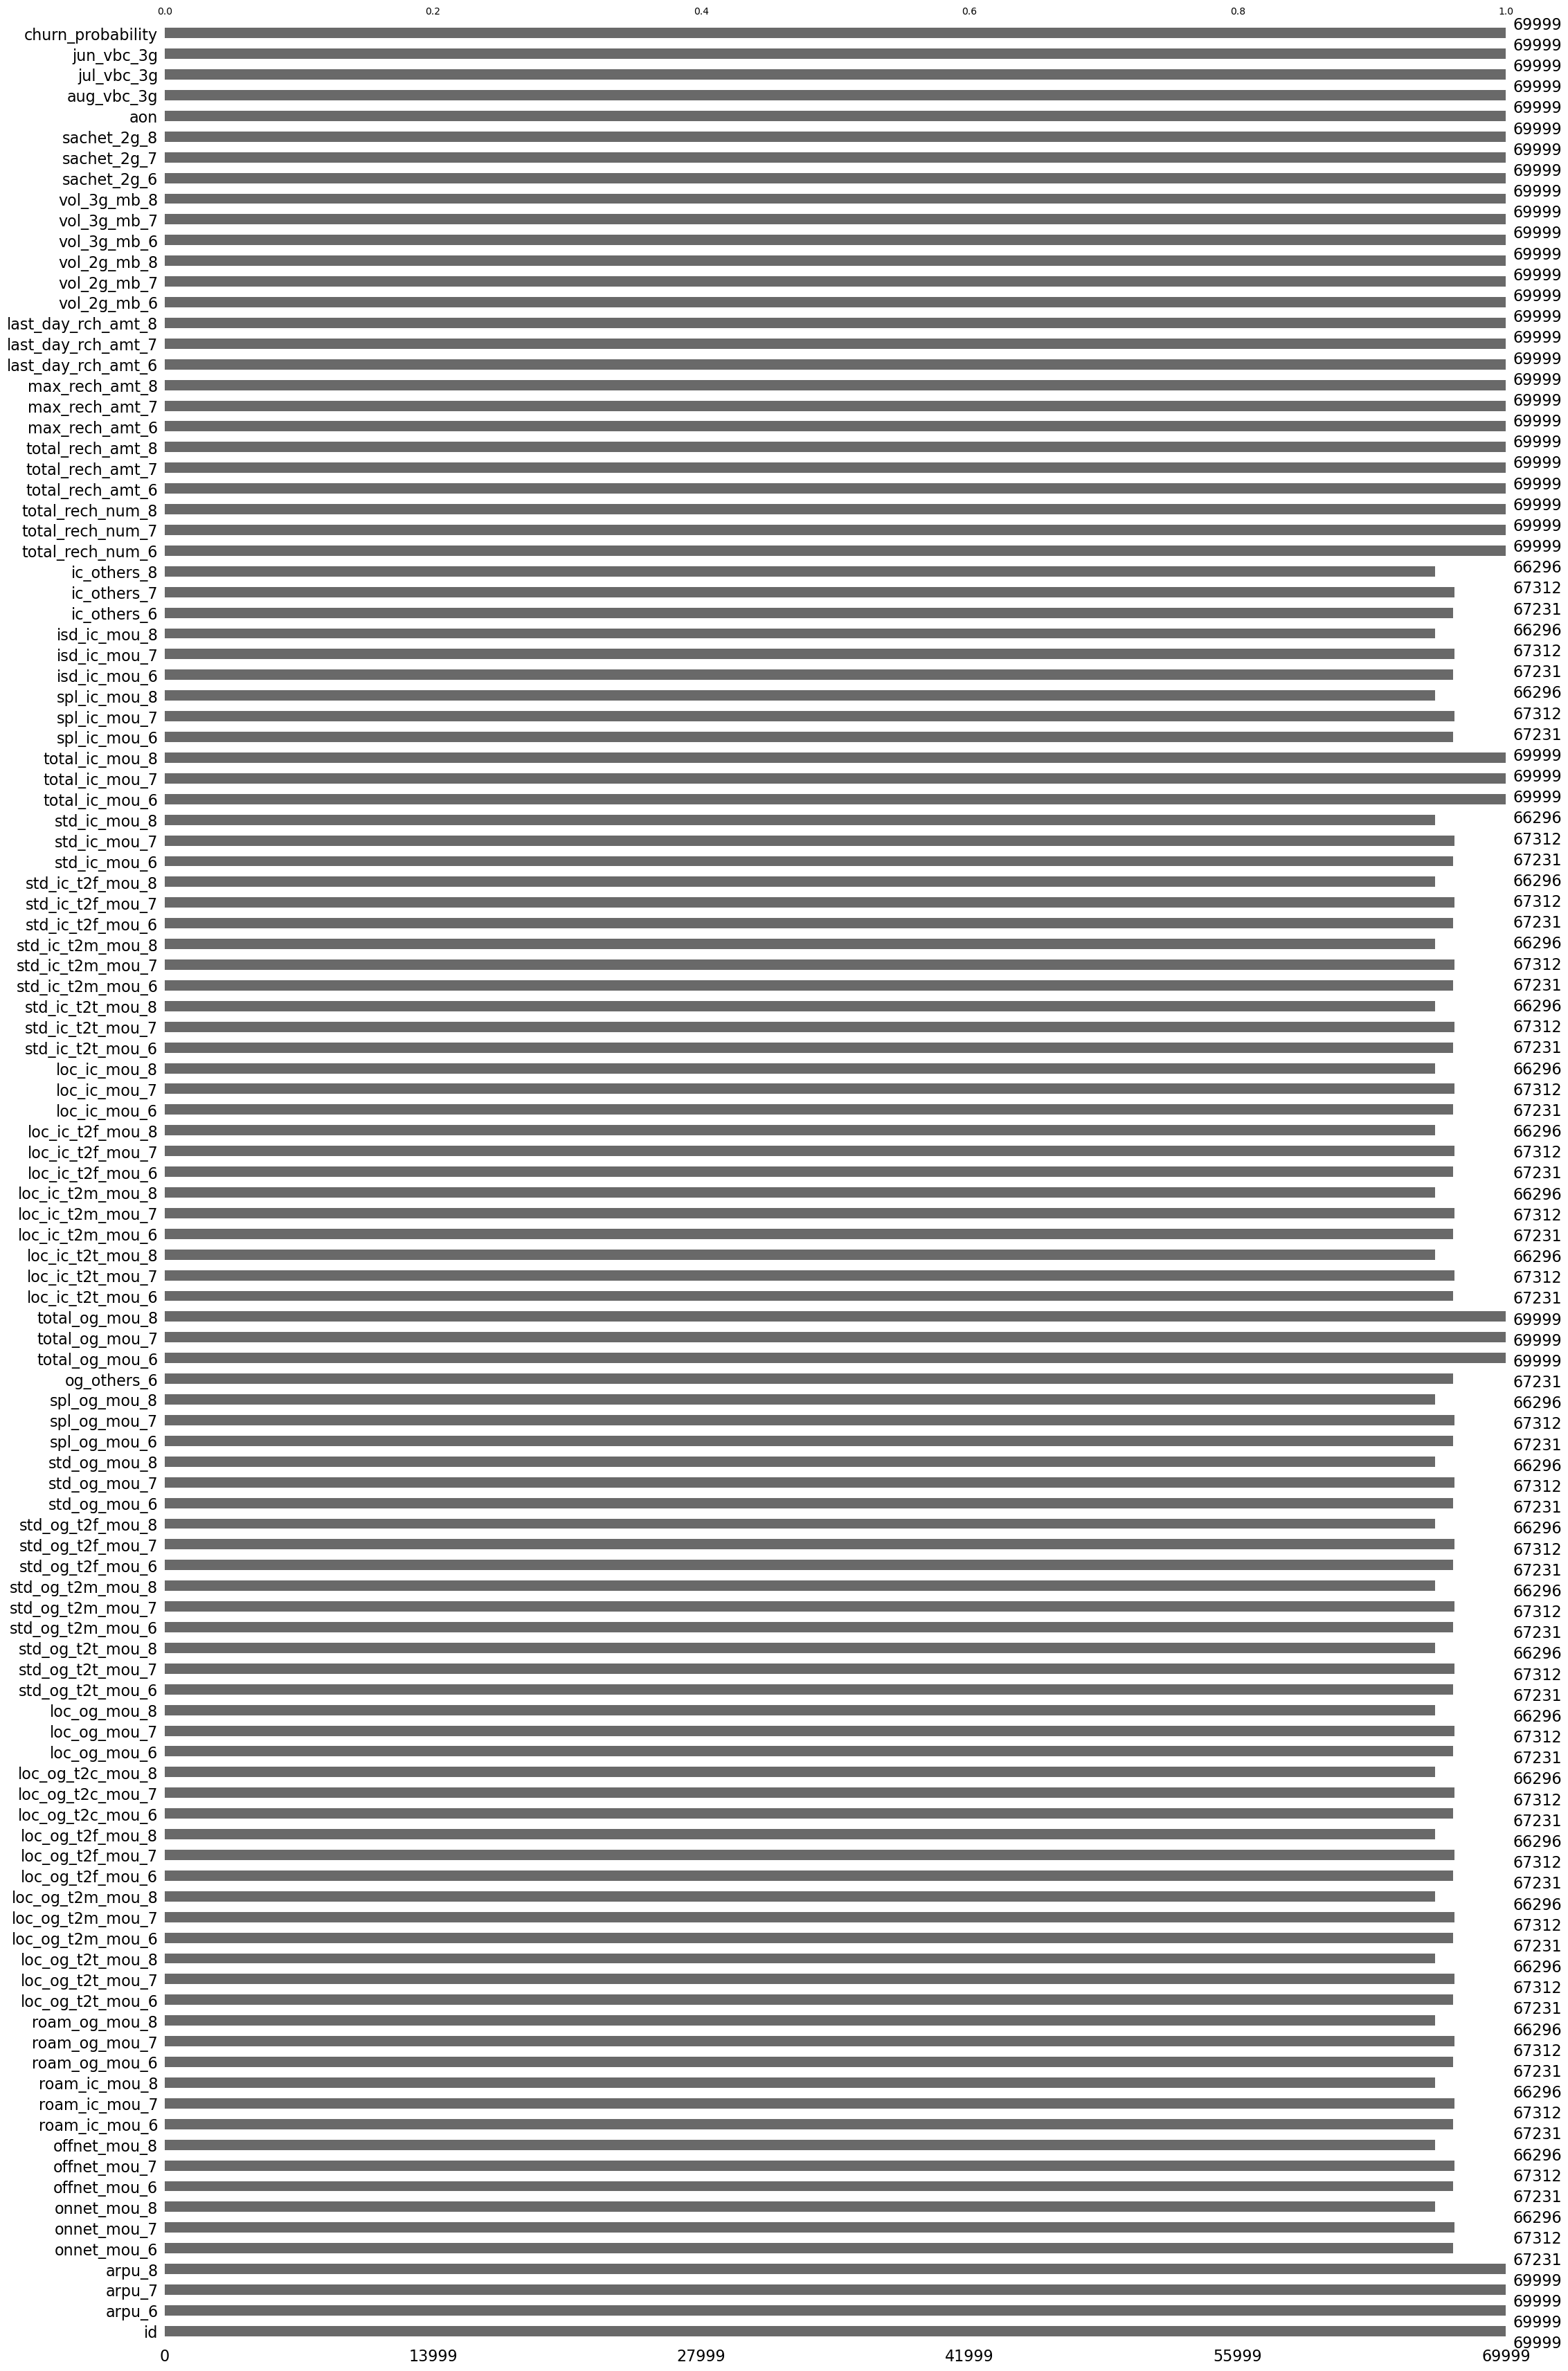

In [17]:
msno.bar(data)

In [18]:
# Count the rows having more than 50% missing values
#data_missing_rows_50 = data[(data.isnull().sum(axis=1)) > (len(data.columns)//2)]
#data_missing_rows_50.shape

In [19]:
# Deleting the rows having more than 50% missing values
#data = data.drop(data_missing_rows_50.index)
#data.shape

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 112 entries, id to churn_probability
dtypes: float64(94), int64(18)
memory usage: 59.8 MB


In [21]:
print(list(data.columns))

['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou

In [22]:
data[['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']].describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8
count      69999.000000      69999.000000      69999.000000
mean         328.139788        322.376363        323.846355
std          404.211068        411.070120        426.181405
min            0.000000          0.000000          0.000000
1%             0.000000          0.000000          0.000000
10%            0.000000          0.000000          0.000000
25%          110.000000        100.000000         90.000000
50%          229.000000        220.000000        225.000000
75%          438.000000        430.000000        436.000000
90%          735.000000        730.000000        734.000000
95%          998.000000        986.100000        988.000000
99%         1683.020000       1712.000000       1706.020000
max        35190.000000      40335.000000      45320.000000

In [23]:
data.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  69999.000000  69999.000000  69999.000000  69999.000000  67231.000000   
mean   34999.000000    283.134365    278.185912    278.858826    133.153275   
std    20207.115084    334.213918    344.366927    351.924315    299.963093   
min        0.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
1%       699.980000      0.000000      0.000000      0.000000      0.000000   
10%     6999.800000     32.248600     29.761200     18.210600      0.260000   
25%    17499.500000     93.581000     86.714000     84.095000      7.410000   
50%    34999.000000    197.484000    191.588000    192.234000     34.110000   
75%    52498.500000    370.791000    365.369500    369.909000    119.390000   
90%    62998.200000    619.993800    615.661400    614.994600    345.080000   
95%    66498.100000    832.022700    823.236700    828.464700    617.185000   
99%    69298.020000   1400.276640   1414.891380   1445.054800   1447.098000   
max    69998.000000  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  67312.000000  66296.000000  67231.000000  67312.000000  66296.000000   
mean     133.894438    132.978257    198.874771    197.153383    196.543577   
std      311.277193    311.896596    316.818355    322.482226    324.089234   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
1%         0.000000      0.000000      0.000000      0.000000      0.000000   
10%        0.150000      0.000000      7.260000      6.431000      5.690000   
25%        6.675000      6.410000     34.860000     32.240000     31.575000   
50%       32.280000     32.100000     96.480000     91.885000     91.800000   
75%      115.837500    115.060000    232.990000    227.630000    229.345000   
90%      347.908000    343.695000    482.030000    482.071000    486.980000   
95%      628.437500    620.240000    735.985000    747.558000    738.017500   
99%     1478.540900   1472.480500   1546.471000   1545.104000   1522.474000   
max     8157.780000  10752.560000   8362.360000   7043.980000  14007.340000   

       roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
count   67231.000000   67312.000000   66296.000000   67231.000000   
mean        9.765435       7.014568       7.004892      14.186457   
std        57.374429      55.960985      53.408135      73.469261   
min         0.000000       0.000000       0.000000       0.000000   
1%          0.000000       0.000000       0.000000       0.000000   
10%         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%        11.950000       5.039000       5.210000      22.710000   
95%        41.350000      23.199000      23.990000      69.455000   
99%       219.649000     153.006700     159.714000     290.851000   
max      2850.980000    4155.830000    4169.810000    3775.110000   

       roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   67312.000000   66296.000000      67231.000000      67312.000000   
mean        9.842191       9.771783         46.904854         46.166503   
std        58.511894      64.618388        150.971758        154.739002   
min         0.000000       0.000000          0.000000          0.000000   
1%          0.000000       0.000000          0.000000          0.000000   
10%         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.650000   
50%         0.000000       0.000000         11.910000         11.580000   
75%         0.000000       0.000000         40.740000         39.760000   
90%         9.900000       9.270000        104.510000        101.039000   
95%        

In [24]:
# Cheking percent of missing values in columns
df_missing_columns = (round(((data.isnull().sum()/len(data.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns.sort_values('null', ascending=False)

null
std_ic_t2t_mou_8    5.29
spl_og_mou_8        5.29
std_ic_t2f_mou_8    5.29
loc_og_t2c_mou_8    5.29
ic_others_8         5.29
std_og_t2m_mou_8    5.29
isd_ic_mou_8        5.29
std_og_mou_8        5.29
spl_ic_mou_8        5.29
offnet_mou_8        5.29
std_ic_mou_8        5.29
std_og_t2t_mou_8    5.29
roam_ic_mou_8       5.29
onnet_mou_8         5.29
roam_og_mou_8       5.29
loc_ic_mou_8        5.29
std_ic_t2m_mou_8    5.29
loc_ic_t2m_mou_8    5.29
loc_ic_t2f_mou_8    5.29
loc_og_t2f_mou_8    5.29
loc_ic_t2t_mou_8    5.29
loc_og_t2m_mou_8    5.29
loc_og_mou_8        5.29
std_og_t2f_mou_8    5.29
loc_og_t2t_mou_8    5.29
offnet_mou_6        3.95
roam_og_mou_6       3.95
loc_og_t2f_mou_6    3.95
onnet_mou_6         3.95
std_og_t2m_mou_6    3.95
std_og_t2f_mou_6    3.95
loc_og_mou_6        3.95
loc_og_t2c_mou_6    3.95
loc_og_t2t_mou_6    3.95
roam_ic_mou_6       3.95
std_og_t2t_mou_6    3.95
og_others_6         3.95
loc_og_t2m_mou_6    3.95
std_ic_t2m_mou_6    3.95
std_og_mou_6        3.95
std_ic_t2t_mou_6    3.95
ic_others_6         3.95
loc_ic_t2t_mou_6    3.95
spl_og_mou_6        3.95
loc_ic_t2f_mou_6    3.95
loc_ic_t2m_mou_6    3.95
loc_ic_mou_6        3.95
std_ic_t2f_mou_6    3.95
std_ic_mou_6        3.95
spl_ic_mou_6        3.95
isd_ic_mou_6        3.95
spl_og_mou_7        3.84
std_og_t2t_mou_7    3.84
loc_ic_mou_7        3.84
std_og_mou_7        3.84
loc_ic_t2t_mou_7    3.84
loc_og_t2f_mou_7    3.84
std_og_t2m_mou_7    3.84
loc_ic_t2m_mou_7    3.84
loc_og_t2c_mou_7    3.84
loc_ic_t2f_mou_7    3.84
loc_og_t2m_mou_7    3.84
loc_og_mou_7        3.84
std_ic_t2t_mou_7    3.84
std_ic_t2m_mou_7    3.84
roam_ic_mou_7       3.84
std_ic_mou_7        3.84
loc_og_t2t_mou_7    3.84
roam_og_mou_7       3.84
std_og_t2f_mou_7    3.84
std_ic_t2f_mou_7    3.84
offnet_mou_7        3.84
spl_ic_mou_7        3.84
onnet_mou_7         3.84
isd_ic_mou_7        3.84
ic_others_7         3.84
total_ic_mou_6      0.00
arpu_7              0.00
arpu_8              0.00
total_og_mou_6      0.00
total_og_mou_7      0.00
total_og_mou_8      0.00
arpu_6              0.00
total_rech_amt_6    0.00
total_ic_mou_7      0.00
total_ic_mou_8      0.00
total_rech_num_6    0.00
total_rech_num_7    0.00
total_rech_num_8    0.00
max_rech_amt_7      0.00
total_rech_amt_7    0.00
total_rech_amt_8    0.00
max_rech_amt_6      0.00
vol_3g_mb_8         0.00
id                  0.00
last_day_rch_amt_6  0.00
vol_2g_mb_6         0.00
vol_2g_mb_7         0.00
vol_2g_mb_8         0.00
vol_3g_mb_6         0.00
last_day_rch_amt_7  0.00
jun_vbc_3g          0.00
last_day_rch_amt_8  0.00
aug_vbc_3g          0.00
jul_vbc_3g          0.00
max_rech_amt_8      0.00
aon                 0.00
vol_3g_mb_7         0.00
sachet_2g_6         0.00
sachet_2g_8         0.00
sachet_2g_7         0.00
churn_probability   0.00

In [25]:
data.shape

(69999, 112)

In [26]:
#imputed 
data = data.fillna(0)

In [27]:
data.isnull().sum()

id                    0
arpu_6                0
arpu_7                0
arpu_8                0
onnet_mou_6           0
onnet_mou_7           0
onnet_mou_8           0
offnet_mou_6          0
offnet_mou_7          0
offnet_mou_8          0
roam_ic_mou_6         0
roam_ic_mou_7         0
roam_ic_mou_8         0
roam_og_mou_6         0
roam_og_mou_7         0
roam_og_mou_8         0
loc_og_t2t_mou_6      0
loc_og_t2t_mou_7      0
loc_og_t2t_mou_8      0
loc_og_t2m_mou_6      0
loc_og_t2m_mou_7      0
loc_og_t2m_mou_8      0
loc_og_t2f_mou_6      0
loc_og_t2f_mou_7      0
loc_og_t2f_mou_8      0
loc_og_t2c_mou_6      0
loc_og_t2c_mou_7      0
loc_og_t2c_mou_8      0
loc_og_mou_6          0
loc_og_mou_7          0
loc_og_mou_8          0
std_og_t2t_mou_6      0
std_og_t2t_mou_7      0
std_og_t2t_mou_8      0
std_og_t2m_mou_6      0
std_og_t2m_mou_7      0
std_og_t2m_mou_8      0
std_og_t2f_mou_6      0
std_og_t2f_mou_7      0
std_og_t2f_mou_8      0
std_og_mou_6          0
std_og_mou_7    

<Axes: >

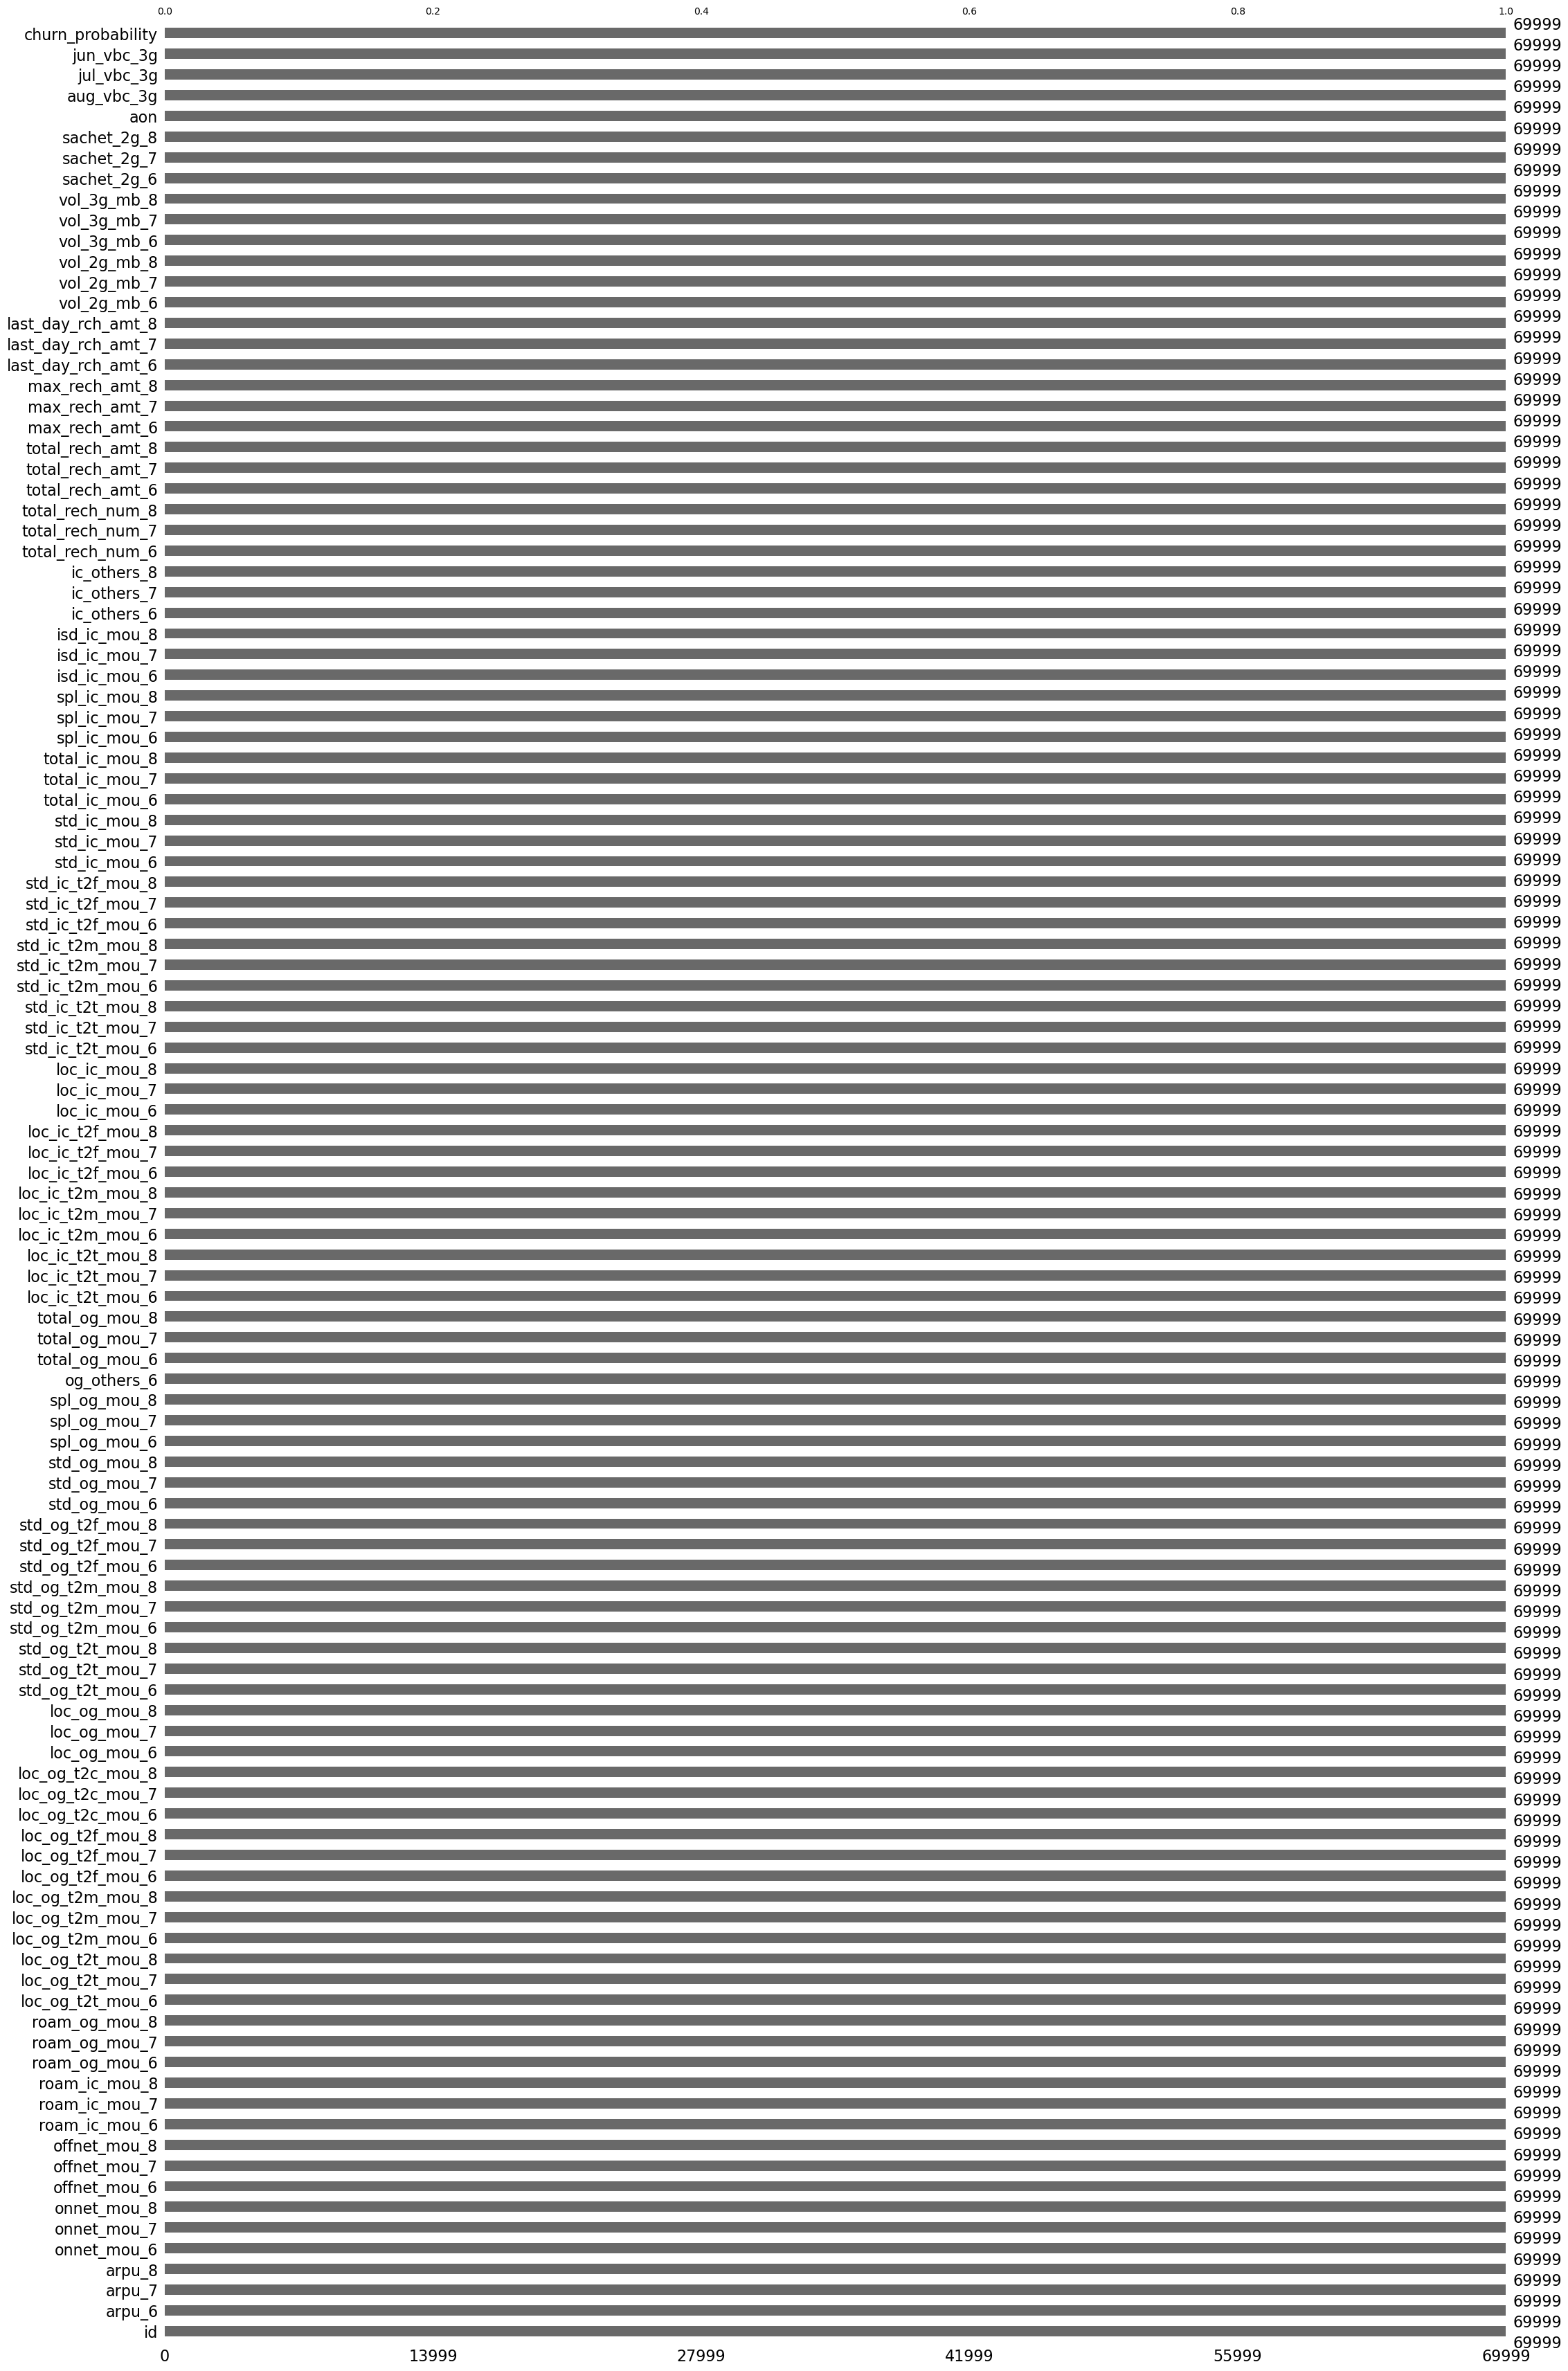

In [28]:
msno.bar(data)

In [29]:
data.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean   34999.000000    283.134365    278.185912    278.858826    127.887939   
std    20207.115084    334.213918    344.366927    351.924315    295.115497   
min        0.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
1%       699.980000      0.000000      0.000000      0.000000      0.000000   
10%     6999.800000     32.248600     29.761200     18.210600      0.000000   
25%    17499.500000     93.581000     86.714000     84.095000      5.430000   
50%    34999.000000    197.484000    191.588000    192.234000     30.830000   
75%    52498.500000    370.791000    365.369500    369.909000    113.100000   
90%    62998.200000    619.993800    615.661400    614.994600    331.766000   
95%    66498.100000    832.022700    823.236700    828.464700    598.600000   
99%    69298.020000   1400.276640   1414.891380   1445.054800   1429.040400   
max    69998.000000  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean     128.754731    125.943607    191.010582    189.585401    186.146273   
std      306.326345    304.990552    312.900706    318.492632    318.453812   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
1%         0.000000      0.000000      0.000000      0.000000      0.000000   
10%        0.000000      0.000000      2.030000      1.800000      0.280000   
25%        4.910000      4.110000     28.790000     26.690000     23.780000   
50%       29.160000     27.840000     89.810000     85.590000     83.010000   
75%      108.940000    106.280000    223.540000    218.350000    216.410000   
90%      334.886000    326.298000    468.898000    470.054000    467.636000   
95%      608.878000    596.125000    719.500000    731.602000    715.915000   
99%     1461.342200   1448.891000   1520.310000   1517.838600   1492.232400   
max     8157.780000  10752.560000   8362.360000   7043.980000  14007.340000   

       roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
count   69999.000000   69999.000000   69999.000000   69999.000000   
mean        9.379276       6.745305       6.634328      13.625476   
std        56.260778      54.892940      51.999899      72.055036   
min         0.000000       0.000000       0.000000       0.000000   
1%          0.000000       0.000000       0.000000       0.000000   
10%         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%        10.890000       4.392000       4.280000      20.864000   
95%        38.842000      21.562000      21.992000      65.931000   
99%       213.827400     149.030200     150.231600     284.721400   
max      2850.980000    4155.830000    4169.810000    3775.110000   

       roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   69999.000000   69999.000000      69999.000000      69999.000000   
mean        9.464386       9.254848         45.050076         44.394344   
std        57.409013      62.923987        148.238746        151.998993   
min         0.000000       0.000000          0.000000          0.000000   
1%          0.000000       0.000000          0.000000          0.000000   
10%         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.010000          1.010000   
50%         0.000000       0.000000         10.660000         10.430000   
75%         0.000000       0.000000         38.680000         37.780000   
90%         8.560000       7.552000        101.114000         98.110000   
95%        

In [30]:
#Check for outliers


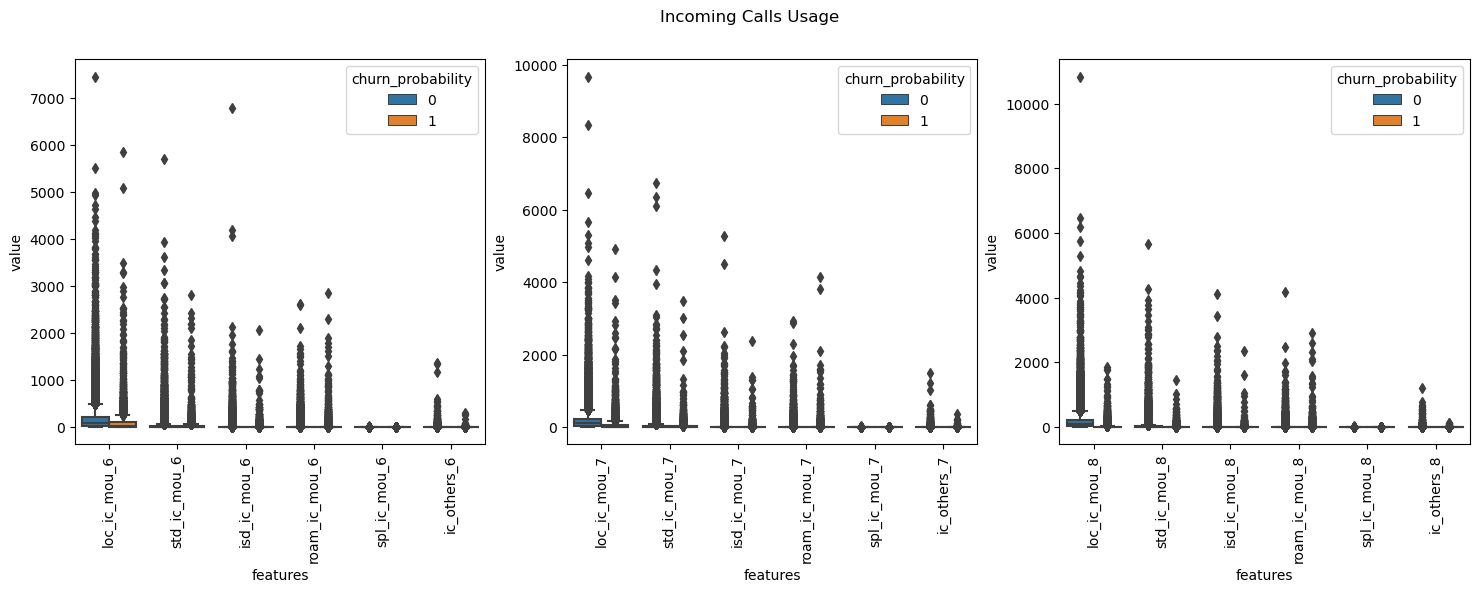

In [31]:
# Ploting the boxplot for the Incoming call usage
cols = [['loc_ic_mou_6','std_ic_mou_6','isd_ic_mou_6','roam_ic_mou_6','spl_ic_mou_6','ic_others_6'],
        ['loc_ic_mou_7','std_ic_mou_7','isd_ic_mou_7','roam_ic_mou_7','spl_ic_mou_7','ic_others_7'],
        ['loc_ic_mou_8','std_ic_mou_8','isd_ic_mou_8','roam_ic_mou_8','spl_ic_mou_8','ic_others_8']]

# plot for the incoming calls usage
plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Incoming Calls Usage')

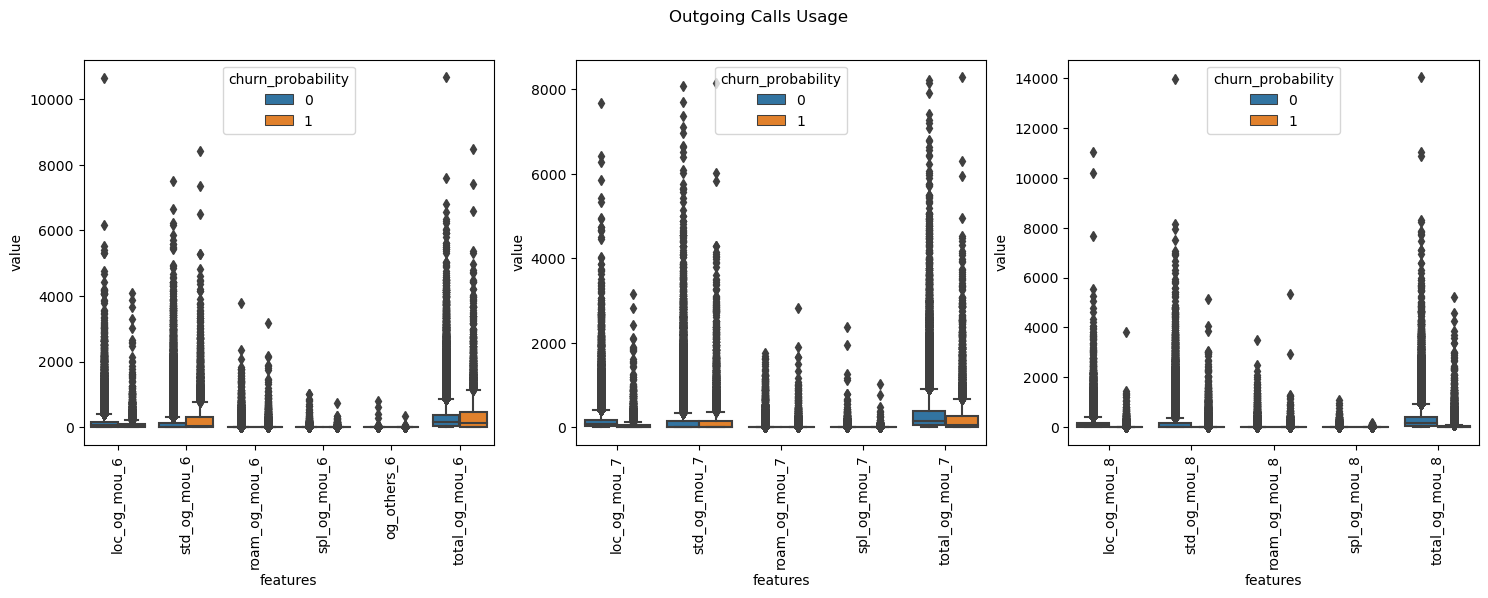

In [32]:
# Plotting the boxplot to vizualise the outgoing calls
cols = [['loc_og_mou_6','std_og_mou_6','roam_og_mou_6','spl_og_mou_6','og_others_6','total_og_mou_6'],
        ['loc_og_mou_7','std_og_mou_7','roam_og_mou_7','spl_og_mou_7','total_og_mou_7'],
        ['loc_og_mou_8','std_og_mou_8','roam_og_mou_8','spl_og_mou_8','total_og_mou_8']]


# plot for the outgoing calls usage
plt.figure(figsize=(18, 5))
#ic call usage
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outgoing Calls Usage')

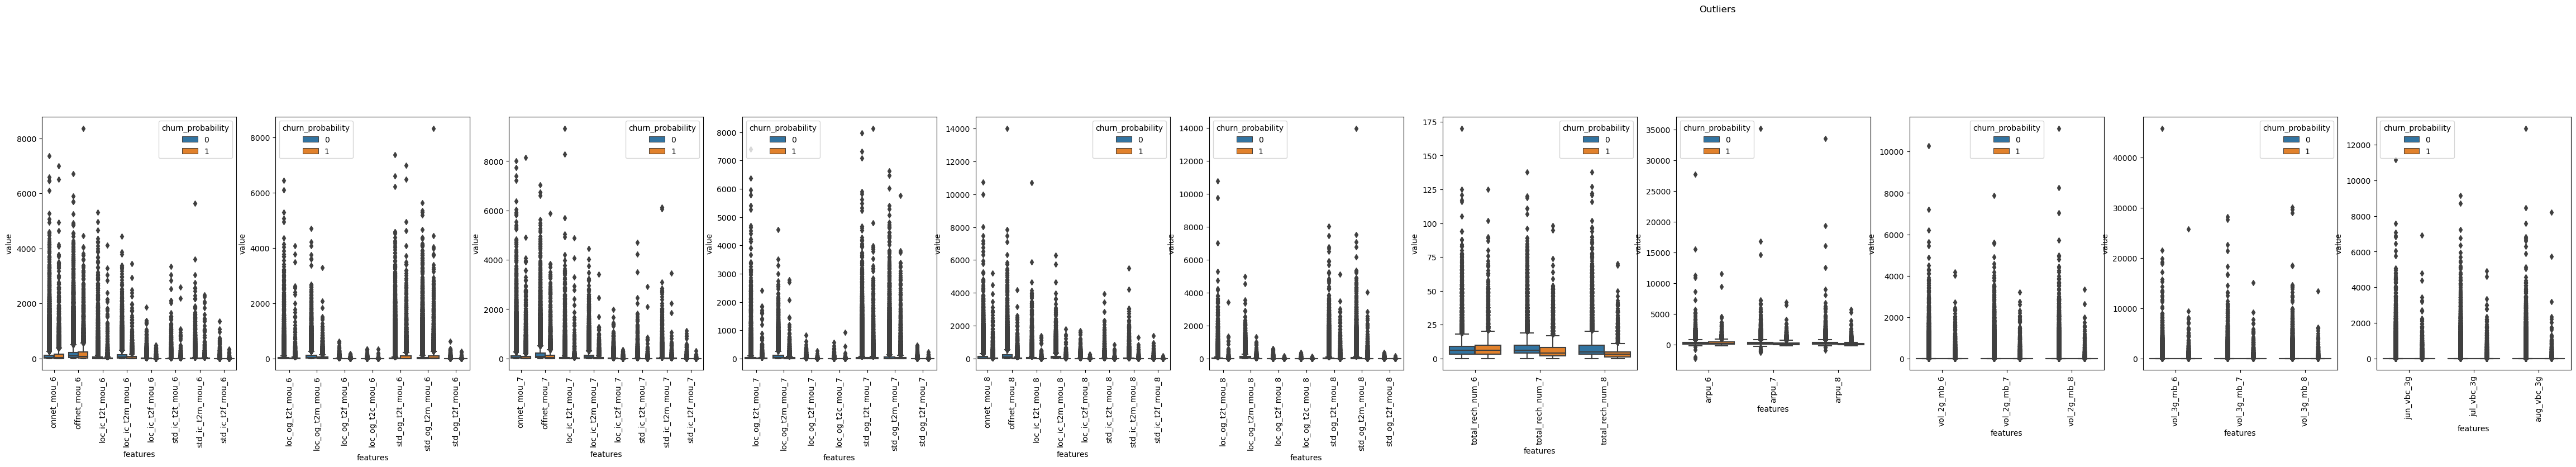

In [33]:
cols=[['onnet_mou_6','offnet_mou_6','loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6'],
        ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','loc_og_t2c_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6'],
        ['onnet_mou_7','offnet_mou_7','loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7'],
        ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','loc_og_t2c_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7'],
        ['onnet_mou_8','offnet_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8'],
        ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','loc_og_t2c_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8'],
        ['total_rech_num_6','total_rech_num_7','total_rech_num_8'], 
        ['arpu_6','arpu_7','arpu_8'],
        ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'],
        ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'],
        ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']]

# plotting the box plot for cols
plt.figure(figsize=(80, 20))
#ic call usage
for i in range(0,11):
    plt.subplot(3, 15, i+1)
    X = pd.concat([data[cols[i]], data['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outliers')

In [34]:
# We observed from Description and visualization that there are many outliers

In [35]:
# Drop Id column
data_id = data.pop('id')
data.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   31.277   87.009    7.527        48.58       124.38         1.29   
1    0.000  122.787   42.953         0.00         0.00         0.00   
2   60.806  103.176    0.000         0.53        15.93         0.00   
3  156.362  205.260  111.095         7.26        16.01         0.00   
4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0         32.24         96.68          2.33           0.00            0.0   
1          0.00         25.99         30.89           0.00            0.0   
2         53.99         82.05          0.00           0.00            0.0   
3         68.76         78.48         50.23           0.00            0.0   
4         56.99         38.11          9.63          53.64            0.0   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.0           0.00            0.0           0.00   
1            0.0           0.00            0.0           0.00   
2            0.0           0.00            0.0           0.00   
3            0.0           0.00            0.0           1.63   
4            0.0          15.73            0.0           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0              2.23              0.00              0.28              5.29   
1              0.00              0.00              0.00              0.00   
2              0.53             12.98              0.00             24.11   
3              6.99              3.94              0.00             37.91   
4             10.16              4.83              6.13             36.74   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0             16.04              2.33              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             44.89             23.63              0.00              0.00   
4             19.88              4.61             11.99              1.23   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              0.00              0.00              0.00              0.00   
1              0.00              0.00             22.01             29.79   
2              0.00              2.14              0.00              0.00   
3              0.00              0.00              0.00              8.03   
4              5.01              0.00              9.85              0.00   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0          7.53         16.04          2.61             46.34   
1          0.00          0.00          0.00              0.00   
2         24.64         12.98          0.00              0.00   
3         44.91         48.84         23.63              0.26   
4         58.91         25.94         15.76              0.00   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0            124.38              1.01             18.75             80.61   
1              0.00              0.00              0.00              0.00   
2              2.94              0.00             28.94             82.05   
3             12.06              0.00             15.33             25.93   
4              0.00              0.00              4.35              0.00   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.0              0.00               0.0               0.0   
1               0.0              0.00               0.0               0.0   
2               0.0              0.00               0.0               0.0   
3               4.6              0.56               0.0               0.0   
4               0.0              0.00               0.0               0.0   

   std_og_mou_6  

In [36]:
# convert the churn_probability column to object for outlier handling
data['churn_probability'] = data['churn_probability'].astype(object)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 111 entries, arpu_6 to churn_probability
dtypes: float64(94), int64(16), object(1)
memory usage: 59.3+ MB


In [37]:
numeric_cols = data.select_dtypes(exclude=['object']).columns
print(list(numeric_cols))

['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', '

In [38]:
data_copy = data.copy()
data_copy.shape

(69999, 111)

In [39]:
for col in numeric_cols:
    q1 = data[col].quantile(0.01)
    q3 = data[col].quantile(0.99)
    iqr = q3-q1
    range_low  = q1-1.5*iqr
    range_high = q3+1.5*iqr
    #print(range_low,' ',range_high)
    data = data.loc[(data[col] > range_low) & (data[col] < range_high)]


In [40]:
data.shape

(63660, 111)

In [41]:
data.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  63660.000000  63660.000000  63660.000000  63660.000000  63660.000000   
mean     255.616389    248.637723    250.313903    111.862458    111.532749   
std      245.241333    242.036695    247.850211    233.488937    238.007589   
min     -160.795000   -282.788000   -345.129000      0.000000      0.000000   
1%         0.000000      0.000000      0.000000      0.000000      0.000000   
10%       29.671000     26.683700     16.250400      0.000000      0.000000   
25%       89.125000     82.216000     79.756750      4.910000      4.360000   
50%      187.116000    180.165500    181.293500     28.790000     26.890000   
75%      345.587250    339.348500    344.325000    103.715000     99.180000   
90%      562.104500    557.222900    561.659300    298.662000    301.580000   
95%      734.583000    725.551300    729.489000    533.135000    545.400000   
99%     1140.225940   1124.103290   1156.405810   1179.041900   1225.841500   
max     2756.099000   2881.842000   2916.372000   3283.660000   2989.810000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  63660.000000  63660.000000  63660.000000  63660.000000   63660.000000   
mean     110.191106    172.339762    169.763431    167.699797       6.274743   
std      239.503976    260.952314    262.469414    259.672942      29.587306   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
1%         0.000000      0.000000      0.000000      0.000000       0.000000   
10%        0.000000      1.580000      1.330000      0.060000       0.000000   
25%        3.610000     26.910000     24.560000     22.060000       0.000000   
50%       25.860000     84.560000     80.020000     77.785000       0.000000   
75%       97.780000    207.345000    201.095000    199.367500       0.000000   
90%      295.699000    428.442000    428.544000    427.430000       8.851000   
95%      538.280500    647.924000    658.038000    649.812500      31.030500   
99%     1219.371100   1304.380200   1291.882000   1284.761700     146.868200   
max     3051.910000   3194.290000   3708.490000   3159.560000     520.710000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   63660.000000   63660.000000   63660.000000   63660.000000   
mean        3.541377       3.525646       9.805715       5.929635   
std        18.257760      18.350464      41.015453      27.685246   
min         0.000000       0.000000       0.000000       0.000000   
1%          0.000000       0.000000       0.000000       0.000000   
10%         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%         3.310000       2.930000      17.410000       6.390000   
95%        15.890000      16.140500      55.190000      31.211000   
99%        90.559700      89.321500     216.234300     147.648200   
max       333.940000     309.890000     622.760000     411.830000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   63660.000000      63660.000000      63660.000000      63660.000000   
mean        5.663997         36.443120         35.142545         34.569631   
std        26.799987         81.949882         77.627631         74.994435   
min         0.000000          0.000000          0.000000          0.000000   
1%          0.000000          0.000000          0.000000          0.000000   
10%         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          0.910000          0.890000          0.675000   
50%         0.000000         10.040000          9.810000          9.510000   
75%         0.000000         36.065000         35.230000         34.930000   
90%         5.291000         92.440000

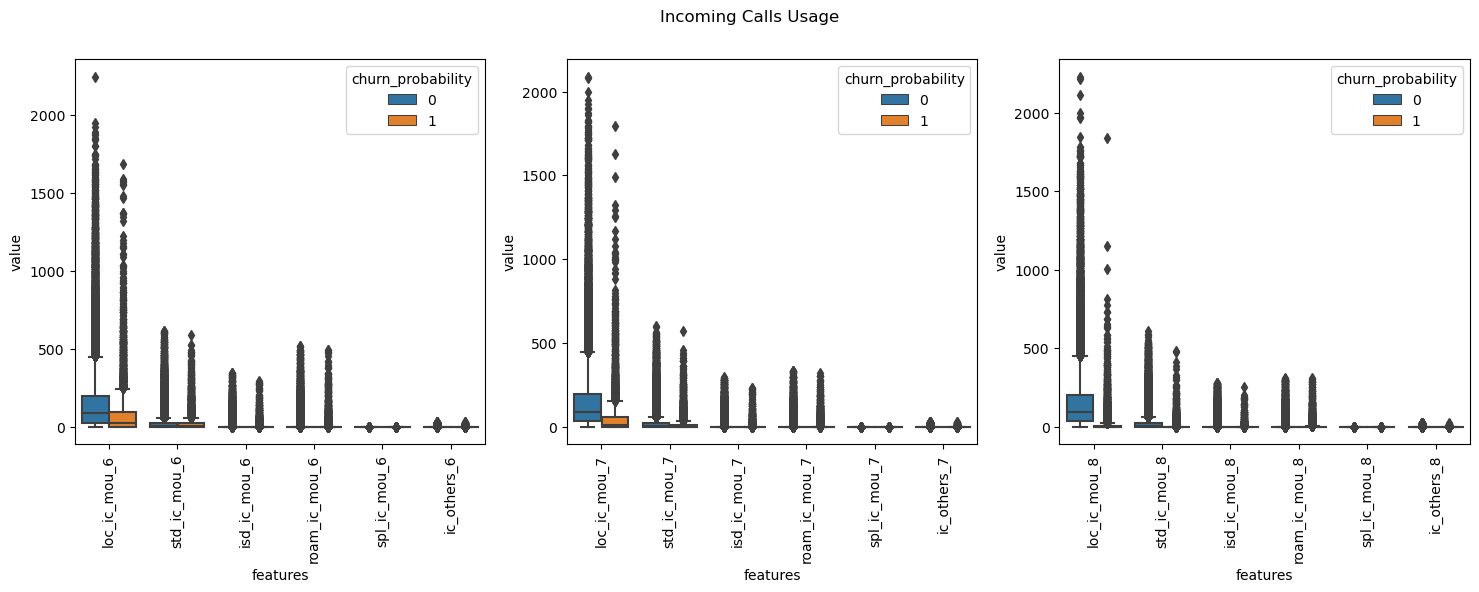

In [42]:
# Ploting the boxplot for the Incoming call usage
cols = [['loc_ic_mou_6','std_ic_mou_6','isd_ic_mou_6','roam_ic_mou_6','spl_ic_mou_6','ic_others_6'],
        ['loc_ic_mou_7','std_ic_mou_7','isd_ic_mou_7','roam_ic_mou_7','spl_ic_mou_7','ic_others_7'],
        ['loc_ic_mou_8','std_ic_mou_8','isd_ic_mou_8','roam_ic_mou_8','spl_ic_mou_8','ic_others_8']]

# plot for the incoming calls usage
plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Incoming Calls Usage')

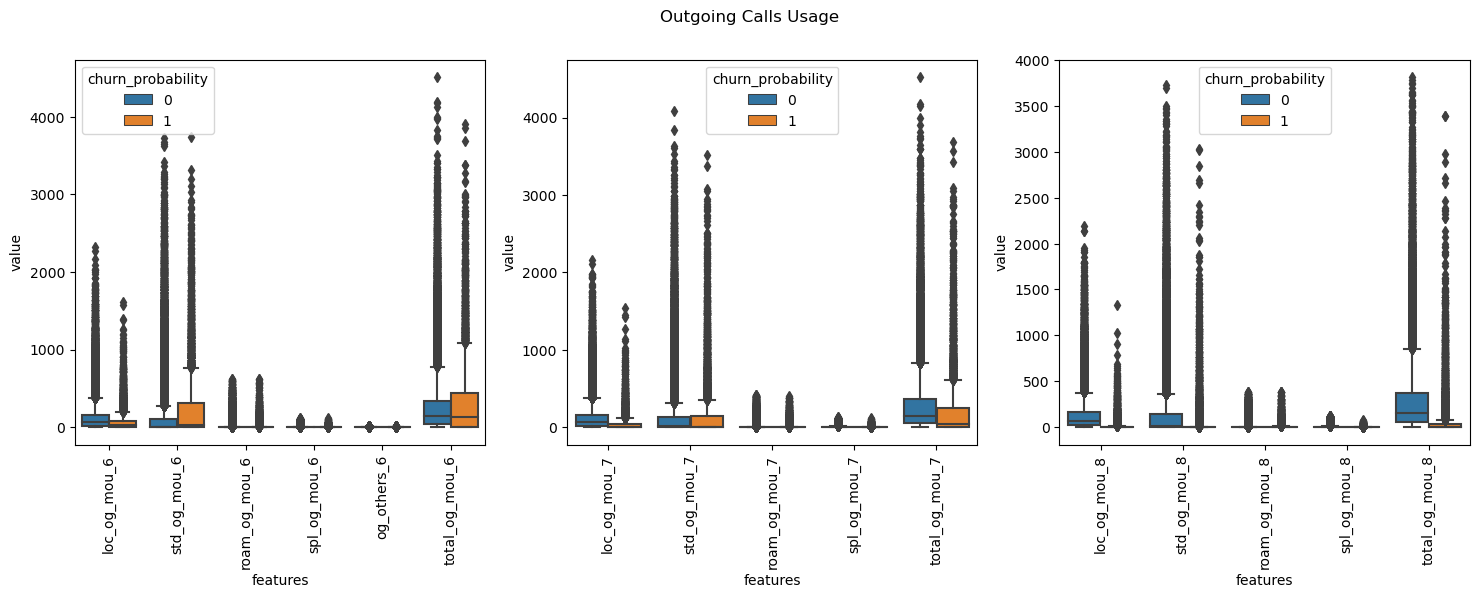

In [43]:
# Plotting the boxplot to vizualise the outgoing calls
cols = [['loc_og_mou_6','std_og_mou_6','roam_og_mou_6','spl_og_mou_6','og_others_6','total_og_mou_6'],
        ['loc_og_mou_7','std_og_mou_7','roam_og_mou_7','spl_og_mou_7','total_og_mou_7'],
        ['loc_og_mou_8','std_og_mou_8','roam_og_mou_8','spl_og_mou_8','total_og_mou_8']]


# plot for the outgoing calls usage
plt.figure(figsize=(18, 5))
#ic call usage
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outgoing Calls Usage')

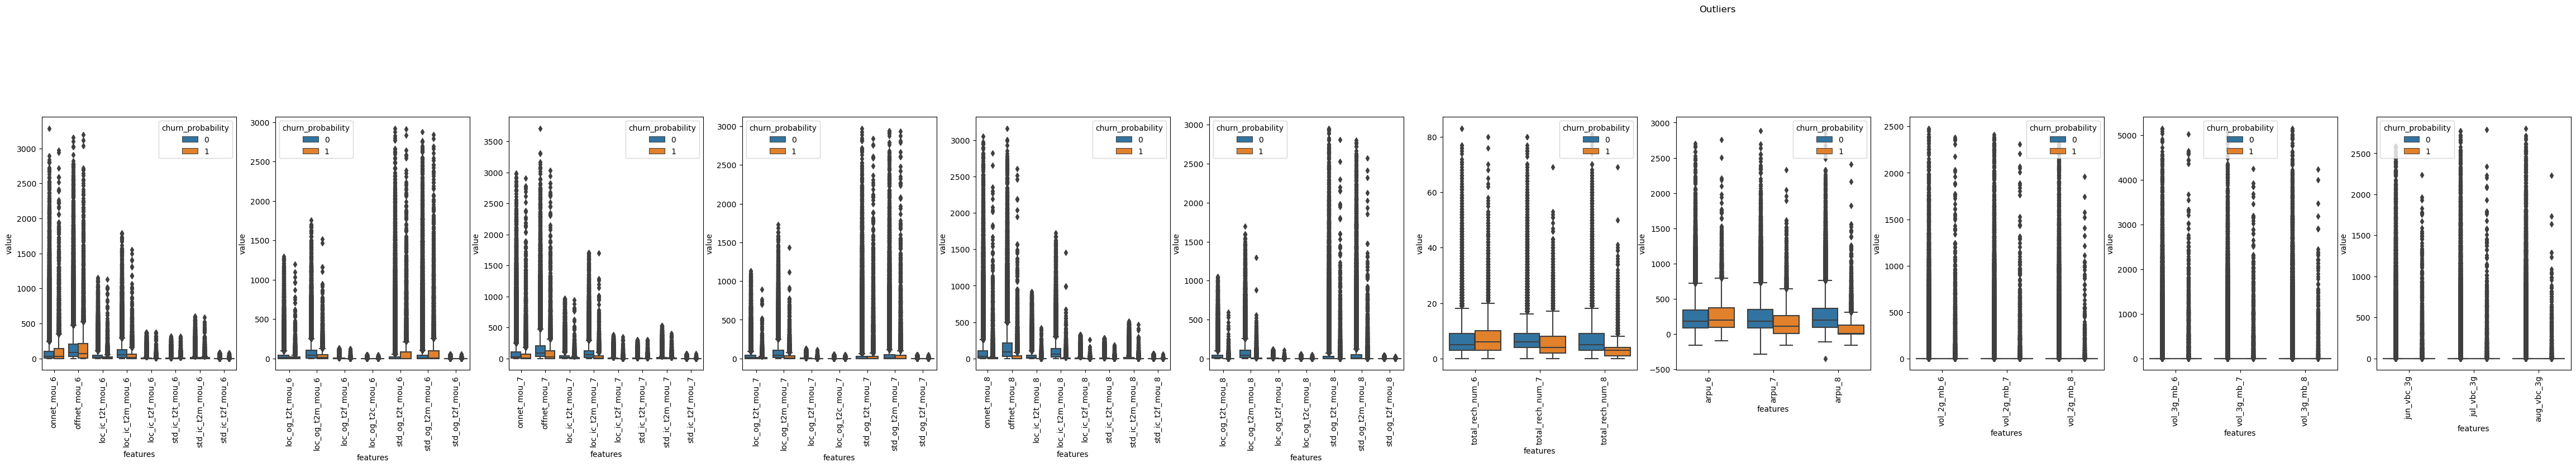

In [44]:
cols=[['onnet_mou_6','offnet_mou_6','loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6'],
        ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','loc_og_t2c_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6'],
        ['onnet_mou_7','offnet_mou_7','loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7'],
        ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','loc_og_t2c_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7'],
        ['onnet_mou_8','offnet_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8'],
        ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','loc_og_t2c_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8'],
        ['total_rech_num_6','total_rech_num_7','total_rech_num_8'], 
        ['arpu_6','arpu_7','arpu_8'],
        ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'],
        ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'],
        ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']]

# plotting the box plot for cols
plt.figure(figsize=(80, 20))
#ic call usage
for i in range(0,11):
    plt.subplot(3, 15, i+1)
    X = pd.concat([data[cols[i]], data['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outliers')

In [45]:
[total for total in data.columns.to_list() if 'total' in total]

['total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8']

In [46]:
#Deriving new column decrease_mou_action
#This column indicates whether the minutes of usage of the customer has decreased.

In [47]:
# Total mou in 1st month incoming and outgoing
data['total_mou_6'] = (data['total_og_mou_6'] + data['total_ic_mou_6'])

In [48]:
data['avg_mou_7_8'] = (data['total_og_mou_7'] + data['total_og_mou_8'] + data['total_ic_mou_7'] + data['total_ic_mou_8'])/2

In [49]:
data['diff_mou'] = data['avg_mou_7_8'] - data['total_mou_6']

In [50]:
data['decrease_mou'] = np.where((data['diff_mou'] < 0), 1, 0)

In [51]:
data.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   31.277   87.009    7.527        48.58       124.38         1.29   
1    0.000  122.787   42.953         0.00         0.00         0.00   
2   60.806  103.176    0.000         0.53        15.93         0.00   
3  156.362  205.260  111.095         7.26        16.01         0.00   
4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0         32.24         96.68          2.33           0.00            0.0   
1          0.00         25.99         30.89           0.00            0.0   
2         53.99         82.05          0.00           0.00            0.0   
3         68.76         78.48         50.23           0.00            0.0   
4         56.99         38.11          9.63          53.64            0.0   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.0           0.00            0.0           0.00   
1            0.0           0.00            0.0           0.00   
2            0.0           0.00            0.0           0.00   
3            0.0           0.00            0.0           1.63   
4            0.0          15.73            0.0           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0              2.23              0.00              0.28              5.29   
1              0.00              0.00              0.00              0.00   
2              0.53             12.98              0.00             24.11   
3              6.99              3.94              0.00             37.91   
4             10.16              4.83              6.13             36.74   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0             16.04              2.33              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             44.89             23.63              0.00              0.00   
4             19.88              4.61             11.99              1.23   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              0.00              0.00              0.00              0.00   
1              0.00              0.00             22.01             29.79   
2              0.00              2.14              0.00              0.00   
3              0.00              0.00              0.00              8.03   
4              5.01              0.00              9.85              0.00   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0          7.53         16.04          2.61             46.34   
1          0.00          0.00          0.00              0.00   
2         24.64         12.98          0.00              0.00   
3         44.91         48.84         23.63              0.26   
4         58.91         25.94         15.76              0.00   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0            124.38              1.01             18.75             80.61   
1              0.00              0.00              0.00              0.00   
2              2.94              0.00             28.94             82.05   
3             12.06              0.00             15.33             25.93   
4              0.00              0.00              4.35              0.00   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.0              0.00               0.0               0.0   
1               0.0              0.00               0.0               0.0   
2               0.0              0.00               0.0               0.0   
3               4.6              0.56               0.0               0.0   
4               0.0              0.00               0.0               0.0   

   std_og_mou_6  

In [52]:
# Deriving new column decrease_rech_num_action
# This column indicates whether the number of recharge of the customer has decreased.

In [53]:
data['avg_rech_num_7_8'] = (data['total_rech_num_7'] + data['total_rech_num_8'])/2
data['diff_rech_num'] = data['avg_rech_num_7_8'] - data['total_rech_num_6']
data['decrease_rech_num'] = np.where((data['diff_rech_num'] < 0), 1, 0)

In [54]:
data.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   31.277   87.009    7.527        48.58       124.38         1.29   
1    0.000  122.787   42.953         0.00         0.00         0.00   
2   60.806  103.176    0.000         0.53        15.93         0.00   
3  156.362  205.260  111.095         7.26        16.01         0.00   
4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0         32.24         96.68          2.33           0.00            0.0   
1          0.00         25.99         30.89           0.00            0.0   
2         53.99         82.05          0.00           0.00            0.0   
3         68.76         78.48         50.23           0.00            0.0   
4         56.99         38.11          9.63          53.64            0.0   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.0           0.00            0.0           0.00   
1            0.0           0.00            0.0           0.00   
2            0.0           0.00            0.0           0.00   
3            0.0           0.00            0.0           1.63   
4            0.0          15.73            0.0           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0              2.23              0.00              0.28              5.29   
1              0.00              0.00              0.00              0.00   
2              0.53             12.98              0.00             24.11   
3              6.99              3.94              0.00             37.91   
4             10.16              4.83              6.13             36.74   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0             16.04              2.33              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             44.89             23.63              0.00              0.00   
4             19.88              4.61             11.99              1.23   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              0.00              0.00              0.00              0.00   
1              0.00              0.00             22.01             29.79   
2              0.00              2.14              0.00              0.00   
3              0.00              0.00              0.00              8.03   
4              5.01              0.00              9.85              0.00   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0          7.53         16.04          2.61             46.34   
1          0.00          0.00          0.00              0.00   
2         24.64         12.98          0.00              0.00   
3         44.91         48.84         23.63              0.26   
4         58.91         25.94         15.76              0.00   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0            124.38              1.01             18.75             80.61   
1              0.00              0.00              0.00              0.00   
2              2.94              0.00             28.94             82.05   
3             12.06              0.00             15.33             25.93   
4              0.00              0.00              4.35              0.00   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.0              0.00               0.0               0.0   
1               0.0              0.00               0.0               0.0   
2               0.0              0.00               0.0               0.0   
3               4.6              0.56               0.0               0.0   
4               0.0              0.00               0.0               0.0   

   std_og_mou_6  

In [55]:
# Deriving new column decrease_rech_amt_action
# This column indicates whether the amount of recharge of the customer has decreased.

In [56]:
data['avg_rech_amt_7_8'] = (data['total_rech_amt_7'] + data['total_rech_amt_8'])/2
data['diff_rech_amt'] = data['avg_rech_amt_7_8'] - data['total_rech_amt_6']
data['decrease_rech_amt'] = np.where((data['diff_rech_amt'] < 0), 1, 0)

In [57]:
data.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   31.277   87.009    7.527        48.58       124.38         1.29   
1    0.000  122.787   42.953         0.00         0.00         0.00   
2   60.806  103.176    0.000         0.53        15.93         0.00   
3  156.362  205.260  111.095         7.26        16.01         0.00   
4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0         32.24         96.68          2.33           0.00            0.0   
1          0.00         25.99         30.89           0.00            0.0   
2         53.99         82.05          0.00           0.00            0.0   
3         68.76         78.48         50.23           0.00            0.0   
4         56.99         38.11          9.63          53.64            0.0   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.0           0.00            0.0           0.00   
1            0.0           0.00            0.0           0.00   
2            0.0           0.00            0.0           0.00   
3            0.0           0.00            0.0           1.63   
4            0.0          15.73            0.0           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0              2.23              0.00              0.28              5.29   
1              0.00              0.00              0.00              0.00   
2              0.53             12.98              0.00             24.11   
3              6.99              3.94              0.00             37.91   
4             10.16              4.83              6.13             36.74   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0             16.04              2.33              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             44.89             23.63              0.00              0.00   
4             19.88              4.61             11.99              1.23   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              0.00              0.00              0.00              0.00   
1              0.00              0.00             22.01             29.79   
2              0.00              2.14              0.00              0.00   
3              0.00              0.00              0.00              8.03   
4              5.01              0.00              9.85              0.00   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0          7.53         16.04          2.61             46.34   
1          0.00          0.00          0.00              0.00   
2         24.64         12.98          0.00              0.00   
3         44.91         48.84         23.63              0.26   
4         58.91         25.94         15.76              0.00   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0            124.38              1.01             18.75             80.61   
1              0.00              0.00              0.00              0.00   
2              2.94              0.00             28.94             82.05   
3             12.06              0.00             15.33             25.93   
4              0.00              0.00              4.35              0.00   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.0              0.00               0.0               0.0   
1               0.0              0.00               0.0               0.0   
2               0.0              0.00               0.0               0.0   
3               4.6              0.56               0.0               0.0   
4               0.0              0.00               0.0               0.0   

   std_og_mou_6  

In [58]:
# Deriving new column decrease_arpu_action
# This column indicates whether the average revenue per customer has decreased.

In [59]:
data['avg_arpu_7_8'] = (data['arpu_7'] + data['arpu_8'])/2
data['diff_arpu'] = data['avg_arpu_7_8'] - data['arpu_6']
data['decrease_arpu'] = np.where(data['diff_arpu'] < 0, 1, 0)

In [60]:
data.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   31.277   87.009    7.527        48.58       124.38         1.29   
1    0.000  122.787   42.953         0.00         0.00         0.00   
2   60.806  103.176    0.000         0.53        15.93         0.00   
3  156.362  205.260  111.095         7.26        16.01         0.00   
4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0         32.24         96.68          2.33           0.00            0.0   
1          0.00         25.99         30.89           0.00            0.0   
2         53.99         82.05          0.00           0.00            0.0   
3         68.76         78.48         50.23           0.00            0.0   
4         56.99         38.11          9.63          53.64            0.0   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.0           0.00            0.0           0.00   
1            0.0           0.00            0.0           0.00   
2            0.0           0.00            0.0           0.00   
3            0.0           0.00            0.0           1.63   
4            0.0          15.73            0.0           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0              2.23              0.00              0.28              5.29   
1              0.00              0.00              0.00              0.00   
2              0.53             12.98              0.00             24.11   
3              6.99              3.94              0.00             37.91   
4             10.16              4.83              6.13             36.74   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0             16.04              2.33              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             44.89             23.63              0.00              0.00   
4             19.88              4.61             11.99              1.23   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              0.00              0.00              0.00              0.00   
1              0.00              0.00             22.01             29.79   
2              0.00              2.14              0.00              0.00   
3              0.00              0.00              0.00              8.03   
4              5.01              0.00              9.85              0.00   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0          7.53         16.04          2.61             46.34   
1          0.00          0.00          0.00              0.00   
2         24.64         12.98          0.00              0.00   
3         44.91         48.84         23.63              0.26   
4         58.91         25.94         15.76              0.00   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0            124.38              1.01             18.75             80.61   
1              0.00              0.00              0.00              0.00   
2              2.94              0.00             28.94             82.05   
3             12.06              0.00             15.33             25.93   
4              0.00              0.00              4.35              0.00   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.0              0.00               0.0               0.0   
1               0.0              0.00               0.0               0.0   
2               0.0              0.00               0.0               0.0   
3               4.6              0.56               0.0               0.0   
4               0.0              0.00               0.0               0.0   

   std_og_mou_6  

In [61]:
# Deriving new column decrease_vbc_action
# This column indicates whether the volume based cost of the customer has decreased

In [62]:
data['avg_vbc_3g_7_8'] = (data['jul_vbc_3g'] + data['aug_vbc_3g'])/2
data['diff_vbc'] = data['avg_vbc_3g_7_8'] - data['jun_vbc_3g']
data['decrease_vbc'] = np.where(data['diff_vbc'] < 0 , 1, 0)

In [63]:
data.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   31.277   87.009    7.527        48.58       124.38         1.29   
1    0.000  122.787   42.953         0.00         0.00         0.00   
2   60.806  103.176    0.000         0.53        15.93         0.00   
3  156.362  205.260  111.095         7.26        16.01         0.00   
4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0         32.24         96.68          2.33           0.00            0.0   
1          0.00         25.99         30.89           0.00            0.0   
2         53.99         82.05          0.00           0.00            0.0   
3         68.76         78.48         50.23           0.00            0.0   
4         56.99         38.11          9.63          53.64            0.0   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.0           0.00            0.0           0.00   
1            0.0           0.00            0.0           0.00   
2            0.0           0.00            0.0           0.00   
3            0.0           0.00            0.0           1.63   
4            0.0          15.73            0.0           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0              2.23              0.00              0.28              5.29   
1              0.00              0.00              0.00              0.00   
2              0.53             12.98              0.00             24.11   
3              6.99              3.94              0.00             37.91   
4             10.16              4.83              6.13             36.74   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0             16.04              2.33              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             44.89             23.63              0.00              0.00   
4             19.88              4.61             11.99              1.23   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              0.00              0.00              0.00              0.00   
1              0.00              0.00             22.01             29.79   
2              0.00              2.14              0.00              0.00   
3              0.00              0.00              0.00              8.03   
4              5.01              0.00              9.85              0.00   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0          7.53         16.04          2.61             46.34   
1          0.00          0.00          0.00              0.00   
2         24.64         12.98          0.00              0.00   
3         44.91         48.84         23.63              0.26   
4         58.91         25.94         15.76              0.00   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0            124.38              1.01             18.75             80.61   
1              0.00              0.00              0.00              0.00   
2              2.94              0.00             28.94             82.05   
3             12.06              0.00             15.33             25.93   
4              0.00              0.00              4.35              0.00   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.0              0.00               0.0               0.0   
1               0.0              0.00               0.0               0.0   
2               0.0              0.00               0.0               0.0   
3               4.6              0.56               0.0               0.0   
4               0.0              0.00               0.0               0.0   

   std_og_mou_6  

In [64]:
# EDA 
data['churn_probability'] = data['churn_probability'].astype('int64')

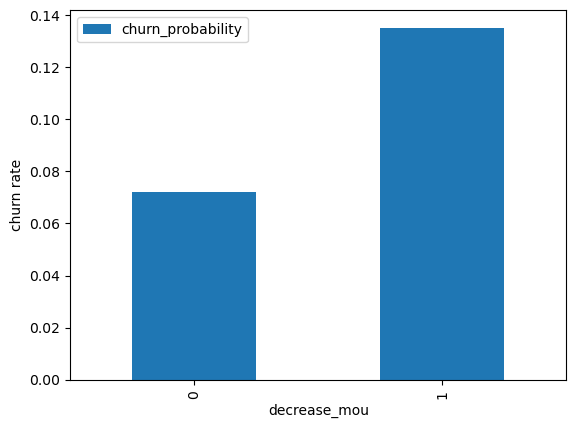

In [65]:
data.pivot_table(values='churn_probability', index='decrease_mou', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

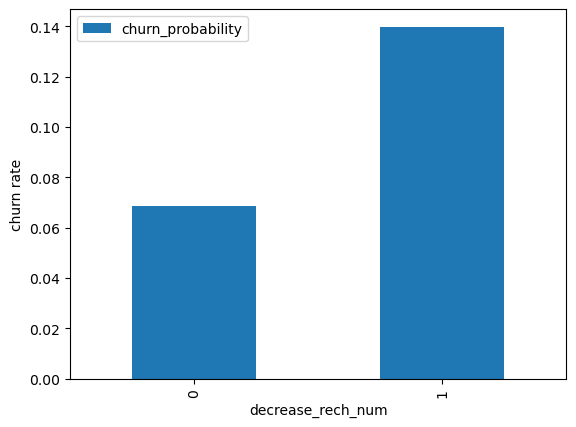

In [66]:
data.pivot_table(values='churn_probability', index='decrease_rech_num', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

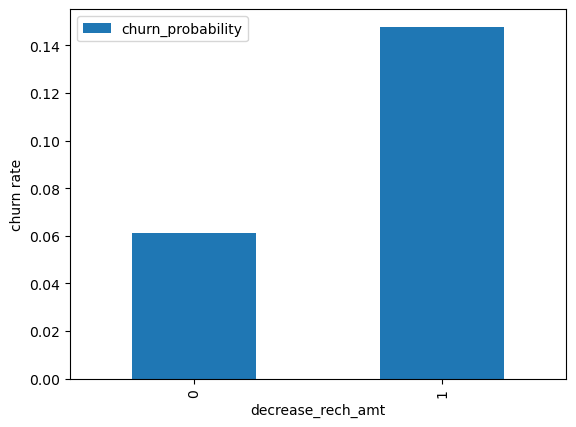

In [67]:
data.pivot_table(values='churn_probability', index='decrease_rech_amt', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

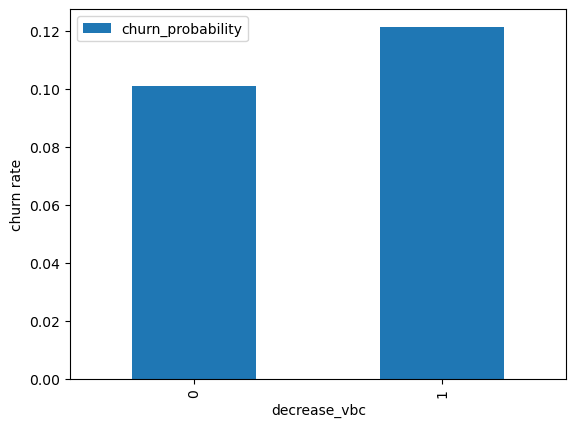

In [68]:
data.pivot_table(values='churn_probability', index='decrease_vbc', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

In [69]:
data.shape

(63660, 127)

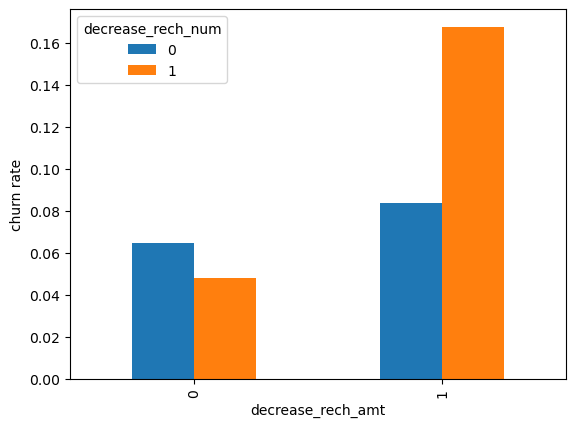

In [70]:
# Bivariate Analysis
data.pivot_table(values='churn_probability', index='decrease_rech_amt', columns='decrease_rech_num', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

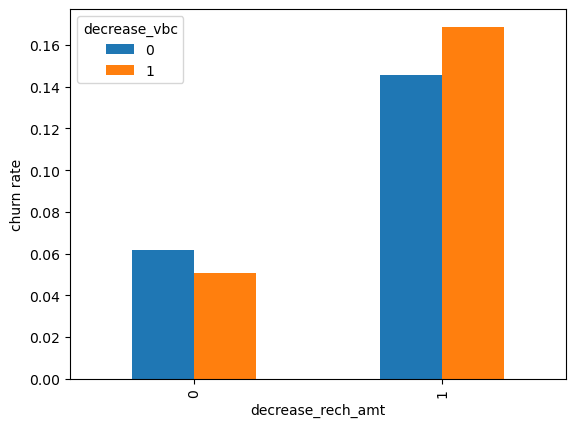

In [71]:
data.pivot_table(values='churn_probability', index='decrease_rech_amt', columns='decrease_vbc', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

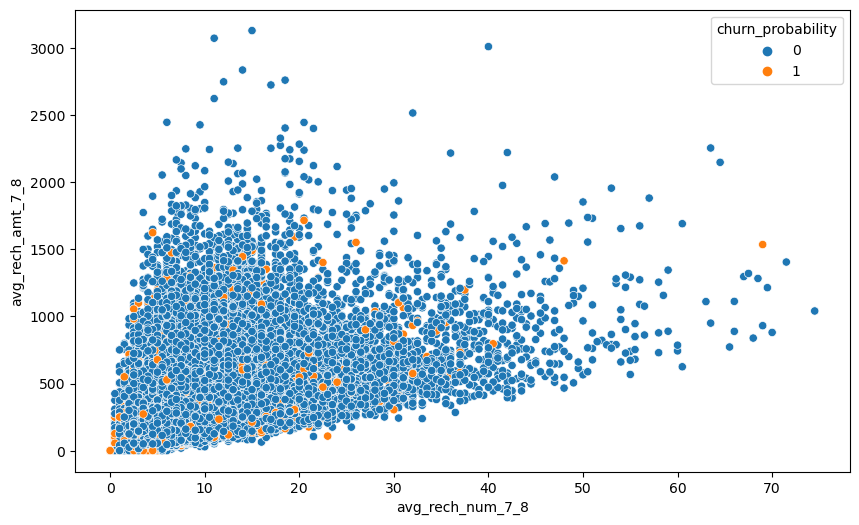

In [73]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='avg_rech_num_7_8',y='avg_rech_amt_7_8', hue='churn_probability', data=data)

In [74]:
# Dropping few derived columns, which are not required in further analysis
data = data.drop(['total_mou_6', 'avg_mou_7_8', 'diff_mou', 'decrease_mou', 'avg_rech_num_7_8', 'diff_rech_num', 
                  'decrease_rech_num', 'avg_rech_amt_7_8', 'diff_rech_amt', 'decrease_rech_amt', 'avg_arpu_7_8', 
                  'diff_arpu', 'decrease_arpu', 'avg_vbc_3g_7_8', 'diff_vbc', 'decrease_vbc'], axis=1)

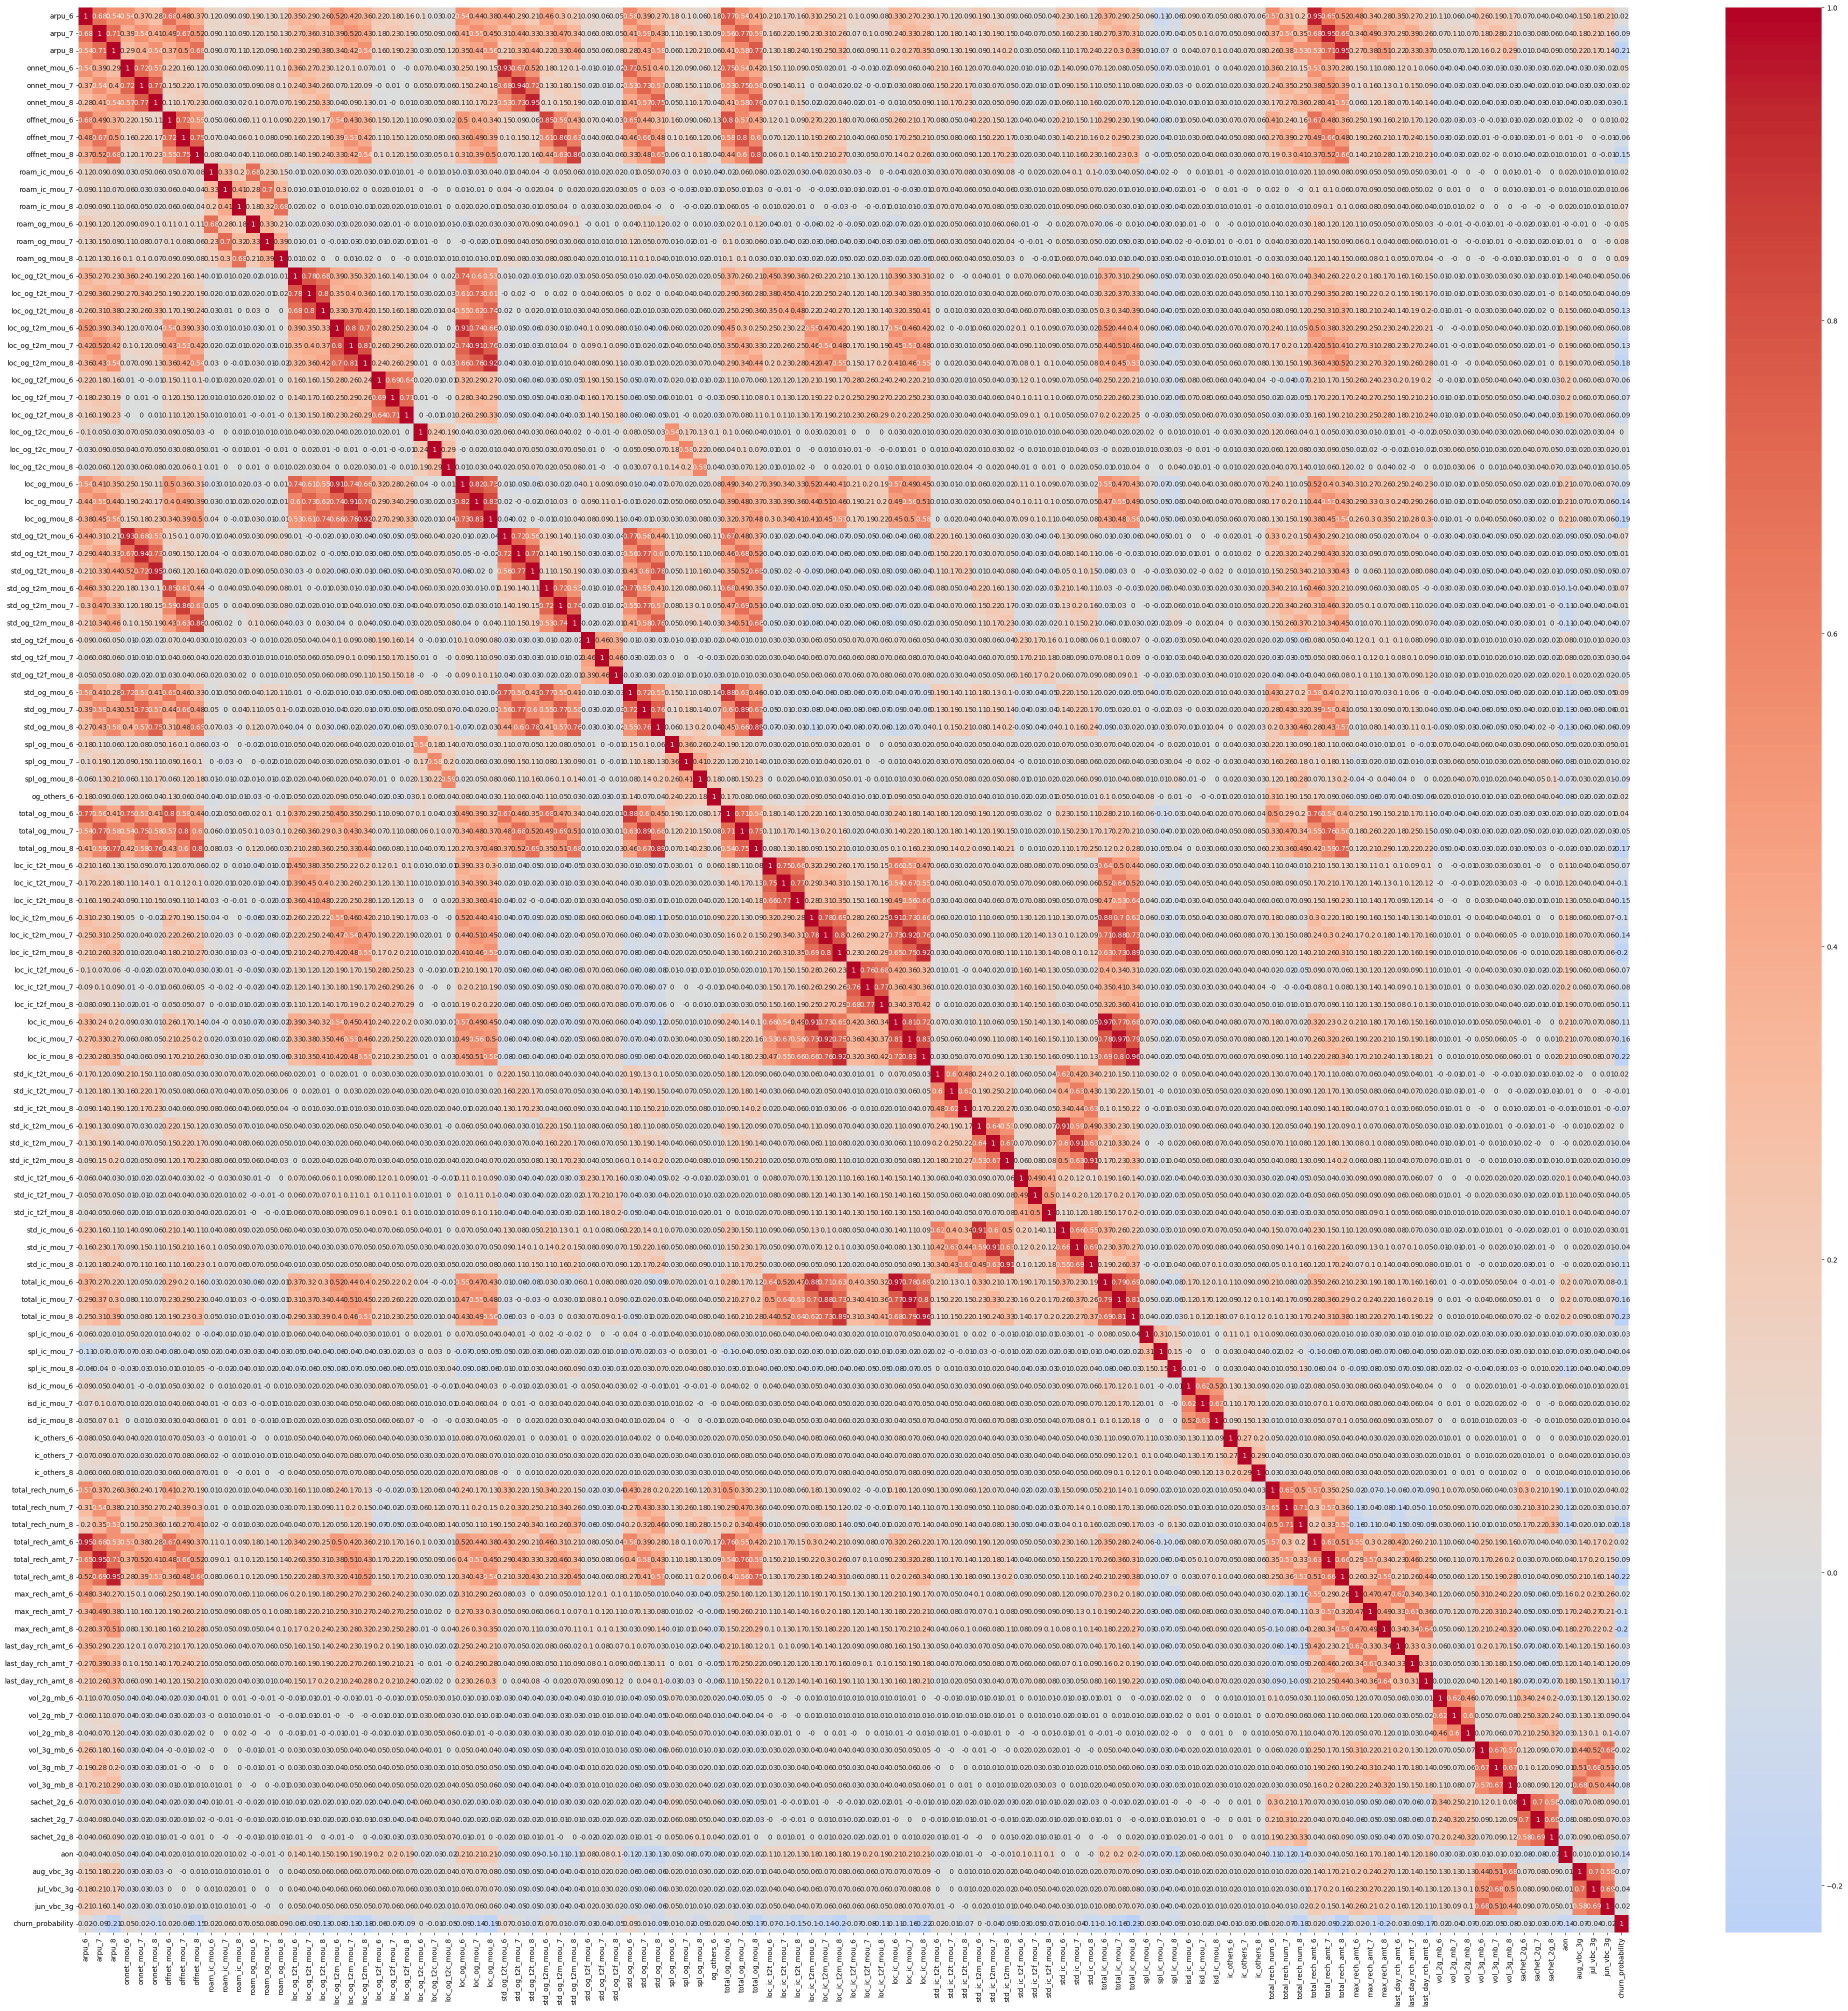

In [75]:
# Checking the corelation
plt.subplots(figsize = (50,50))
#Plotting heatmap of numerical features
sns.heatmap(round(data.corr(),2), cmap='coolwarm' , annot=True, center = 0)
plt.show()

In [76]:
data.shape

(63660, 111)

<Axes: xlabel='churn_probability', ylabel='count'>

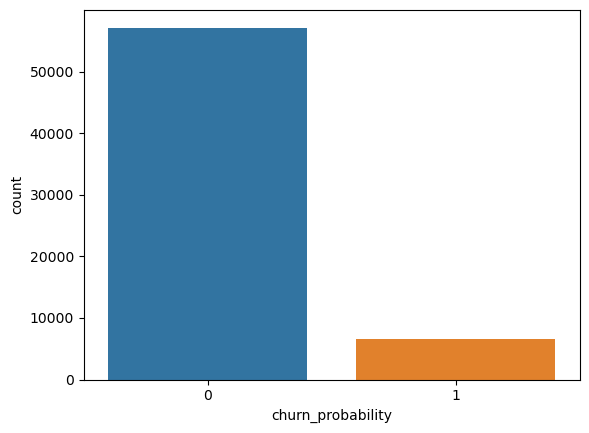

In [79]:
# Check the Churn Probability has any imbalance data
sns.countplot(x='churn_probability',data=data)

In [80]:
data.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  63660.000000  63660.000000  63660.000000  63660.000000  63660.000000   
mean     255.616389    248.637723    250.313903    111.862458    111.532749   
std      245.241333    242.036695    247.850211    233.488937    238.007589   
min     -160.795000   -282.788000   -345.129000      0.000000      0.000000   
1%         0.000000      0.000000      0.000000      0.000000      0.000000   
10%       29.671000     26.683700     16.250400      0.000000      0.000000   
25%       89.125000     82.216000     79.756750      4.910000      4.360000   
50%      187.116000    180.165500    181.293500     28.790000     26.890000   
75%      345.587250    339.348500    344.325000    103.715000     99.180000   
90%      562.104500    557.222900    561.659300    298.662000    301.580000   
95%      734.583000    725.551300    729.489000    533.135000    545.400000   
99%     1140.225940   1124.103290   1156.405810   1179.041900   1225.841500   
max     2756.099000   2881.842000   2916.372000   3283.660000   2989.810000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  63660.000000  63660.000000  63660.000000  63660.000000   63660.000000   
mean     110.191106    172.339762    169.763431    167.699797       6.274743   
std      239.503976    260.952314    262.469414    259.672942      29.587306   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
1%         0.000000      0.000000      0.000000      0.000000       0.000000   
10%        0.000000      1.580000      1.330000      0.060000       0.000000   
25%        3.610000     26.910000     24.560000     22.060000       0.000000   
50%       25.860000     84.560000     80.020000     77.785000       0.000000   
75%       97.780000    207.345000    201.095000    199.367500       0.000000   
90%      295.699000    428.442000    428.544000    427.430000       8.851000   
95%      538.280500    647.924000    658.038000    649.812500      31.030500   
99%     1219.371100   1304.380200   1291.882000   1284.761700     146.868200   
max     3051.910000   3194.290000   3708.490000   3159.560000     520.710000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   63660.000000   63660.000000   63660.000000   63660.000000   
mean        3.541377       3.525646       9.805715       5.929635   
std        18.257760      18.350464      41.015453      27.685246   
min         0.000000       0.000000       0.000000       0.000000   
1%          0.000000       0.000000       0.000000       0.000000   
10%         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%         3.310000       2.930000      17.410000       6.390000   
95%        15.890000      16.140500      55.190000      31.211000   
99%        90.559700      89.321500     216.234300     147.648200   
max       333.940000     309.890000     622.760000     411.830000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   63660.000000      63660.000000      63660.000000      63660.000000   
mean        5.663997         36.443120         35.142545         34.569631   
std        26.799987         81.949882         77.627631         74.994435   
min         0.000000          0.000000          0.000000          0.000000   
1%          0.000000          0.000000          0.000000          0.000000   
10%         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          0.910000          0.890000          0.675000   
50%         0.000000         10.040000          9.810000          9.510000   
75%         0.000000         36.065000         35.230000         34.930000   
90%         5.291000         92.440000

In [82]:
# Now we have to do Data preprocessing 
# Impute Already done
# Feature Scaling to be done
# Data Imbalance to be handled